In [15]:
from collections import defaultdict
from typing import Iterable, Dict, List, Tuple
from random import sample

import numpy as np
import matplotlib.pyplot as plt

from nupack import Complex as NupackComplex
from nupack import Model as NupackModel
from nupack import ComplexSet as NupackComplexSet
from nupack import Strand as NupackStrand
from nupack import SetSpec as NupackSetSpec
from nupack import complex_analysis as nupack_complex_analysis
from nupack import PairsMatrix as NupackPairsMatrix


import dsd.vienna_nupack as dv
import dsd.constraints as dc

# constants
DOMAIN_LENGTH = 15
TEMPERATURE = 37.0
NUPACK_MODEL = NupackModel(material='dna', celsius=TEMPERATURE)
NUMBER_OF_TRIALS = 1000
PLOT_SAMPLE_SIZE = 100
BASE_TO_COLOR = {
    'A': 'blue',
    'C': 'orange',
    'G': 'green',
    'T': 'red',
    'X': 'black',
}

class StrandBaseAddress:
    def __init__(self, strand_idx: int, base_idx: int) -> None:
        self.strand_idx = strand_idx
        self.base_idx = base_idx
        
class BasePairQuery:
    def __init__(self, name:str, addresses: List[StrandBaseAddress]) -> None:
        self.name = name
        self.addresses = addresses
        self.bpps_map = defaultdict(list)

    def plot(self, show_boxplot=False) -> None:
        if len(self.bpps_map) == 0:
            raise ValueError('Query has not been filled yet. Pass this query into nupack_base_pair_probabilities first')
        else:
            plot_bpps_map(self.name, self.bpps_map, show_boxplot=show_boxplot)


class BasePairProbabilityResult:
    def __init__(self, name: str, bpps: np.ndarray, bpps_by_base: Dict[str, List[float]], bpps_by_stack: Dict[str, List[float]], additional_queries: List[BasePairQuery]=list()) -> None:
        self.name = name
        self.bpps = bpps
        self.bpps_by_base = bpps_by_base
        self.bpps_by_stack = bpps_by_stack
        self.additional_queries = additional_queries
        
    def mean_by_base(self, base) -> float:
        return np.mean(self.bpps_by_base[base])
    
    def std_by_base(self, base) -> float:
        return np.std(self.bpps_by_base[base])
    
    def plot_bpps(self) -> None:
        plot_bpps(self.name, self.bpps)
        
    def plot_bpps_by_base(self) -> None:
        plot_bpps_map(self.name, self.bpps_by_base)
    
    def plot_bpps_by_stack(self) -> None:
        plot_bpps_map(self.name, self.bpps_by_stack)

    def plot_all(self) -> None:
        print('Lower Quartile Probability:', self.lower_quartile())
        self.plot_bpps()
        self.plot_bpps_by_base()
        self.plot_bpps_by_stack()
        for query in self.additional_queries:
            query.plot()
            
    def percentile(self, n) -> None:
        return np.percentile(self.bpps, n)
            
    def upper_quartile(self) -> float:
        return np.percentile(self.bpps, 75)
    
    def lower_quartile(self) -> float:
        return np.percentile(self.bpps, 25)


def nupack_base_pair_probabilities(strands: Iterable[dc.Strand], base_index1: int, base_index2: int, name: str, additional_queries: List[BasePairQuery]=list(), domain_length=DOMAIN_LENGTH, skip_domain_pool_setup=False, mismatches=None) -> BasePairProbabilityResult:
    """Given a design and a specific base pair, assigns random DNA sequences to
    the design and computes the equilibrium base-pairing probability for each
    DNA sequence assignment.
    
    :param strands: The strands that make up the design.
    :type strands: Iterable[dc.Strand]
    :param base_index1: The index of one of the bases that form the base pair
    :type base_index1: int
    :param base_index2: The index of the other base that forms the base pair
    :type base_index2: int
    :param name: The name to give to the returned BasePairProbabilityResult
    :type name: str

    :return: An array of NUMBER_OF_TRIALS base pair probabilities and a
        dictionary which sorts the results by base (base located at
        base_index1), and other maps stored in BasePairProbabilityResult
    :rtype: BasePairProbabilityResult
    """
    if mismatches is None:
        mismatches = set()

    domains_to_assign: Set[dc.Domain] = set()
    base_index1_strand_idx: int = 0
    base_index1_strand_base_idx: int
    
    num_bases_in_prev_strands = 0
    num_strands_seen = 0
    for s in strands:
        for d in s.domains:
            if not skip_domain_pool_setup:
                d.pool =  dc.DomainPool('DOMAIN_POOL', domain_length)
            domains_to_assign.add(d)

        if base_index1 < num_bases_in_prev_strands + s.length():
            base_index1_strand_idx = num_strands_seen
            base_index1_strand_base_idx = base_index1 - num_bases_in_prev_strands
        else:
            num_bases_in_prev_strands += s.length()
            num_strands_seen += 1
            
    print('DEBUG: Domains to assign:', domains_to_assign)
    print('DEBUG: Using strand index', base_index1_strand_idx, 'and base index', base_index1_strand_base_idx)
            

    base_pair_probabilities = [0] * NUMBER_OF_TRIALS
    base_pair_probabilities_by_base: Dict[str, List[float]] = defaultdict(list)
    base_pair_probabilities_by_stack: Dict[str, List[float]] = defaultdict(list)
    
    i = 0

    while i < NUMBER_OF_TRIALS:
        # Assign random DNA sequence
        for d in domains_to_assign:
            rand_dna_seq = dv.random_dna_seq(d.length)
            d.sequence = rand_dna_seq
            
        mismatch_was_matched = False
        for (addr1, addr2) in mismatches:
            if dv.wc(strands[addr1.strand_idx].sequence()[addr1.base_idx]) == strands[addr2.strand_idx].sequence()[addr2.base_idx]:
                mismatch_was_matched = True
                break
                
        if mismatch_was_matched:
            continue
        # Initialize NUPACK NupackComplexSet
        nupack_strands = [NupackStrand(strand.sequence(), name=strand.name) for strand in strands]
        nupack_complex: NupackComplex = NupackComplex(nupack_strands)
        nupack_complex_set = NupackComplexSet(nupack_strands, complexes=(nupack_complex,))        
        
        # Call NUPACK complex_analysis 
        nupack_complex_result: np.ndarray = nupack_complex_analysis(nupack_complex_set, compute=['pairs'], model=NUPACK_MODEL)[nupack_complex].pairs.to_array()

            
        # Collect results
        assert nupack_complex_result[base_index1][base_index2] == nupack_complex_result[base_index2][base_index1]
        p = nupack_complex_result[base_index1][base_index2]
        base_pair_probabilities[i] = p
        base_at_base_index1: str = strands[base_index1_strand_idx].sequence()[base_index1_strand_base_idx]
        stack_at_base_index1: str = strands[base_index1_strand_idx].sequence()[base_index1_strand_base_idx - 1: base_index1_strand_base_idx+1]
        base_pair_probabilities_by_base[base_at_base_index1].append(p)
        base_pair_probabilities_by_stack[stack_at_base_index1].append(p)
        
        # Collect results for additional queries
        for query in additional_queries:
            addresses = query.addresses
            query_key = [''] * len(addresses)
            for j, address in enumerate(addresses):
                query_key[j] = strands[address.strand_idx].sequence()[address.base_idx]
            query.bpps_map[''.join(query_key)].append(p)
        
        i += 1
                

        
    return BasePairProbabilityResult(name, np.array(base_pair_probabilities), base_pair_probabilities_by_base, base_pair_probabilities_by_stack, additional_queries)

def summarize_bpps(bpps: np.ndarray, verbose: bool = False) -> None:
    if verbose:
        print('bpps:', bpps)
    print('mean', np.mean(bpps))
    print('standard deviation:', np.std(bpps))
    print()
    
def summarize_bpps_by_base(bpps_by_base: Dict[str, List[float]], verbose: bool = False) -> None:
    for base in 'ACGT':
        bpps = bpps_by_base[base]
        print('base:', base, 'sample size:', len(bpps))
        summarize_bpps(np.array(bpps), verbose=verbose)
        
def summarize_bpps_by_stack(bpps_by_stack: Dict[str, List[float]], verbose: bool = False) -> None:
    for stack, bpps in bpps_by_stack.items():
        print('stack:', stack, 'sample size:', len(bpps))
        summarize_bpps(np.array(bpps), verbose=verbose)
        
def plot_bpps(name: str, bpps: Iterable[float]) -> None:
    plot_bpps_map(name, { 'X': bpps })
    
def plot_vertical_line_every_n(n, limit, lw) -> None:
    for i in range(n, limit, n):
        plt.axvline(x=i+0.5, lw=lw)

def plot_bpps_map(name: str, bpps_map: Dict[str, List[float]], show_boxplot=True) -> None:
    if len(bpps_map) > 10:
        plt.subplots(figsize=(20, 10)) 
    elif len(bpps_map) > 100:
        plt.subplots(figsize=(100, 50))

    bpps_map_keys = []
    lst: List[Tuple[str, List[float]]] = list(bpps_map.items())

    # sort keys by reverse lexiographical order
    lst.sort(key=lambda pair: pair[0][::-1])
    
    for i, (key, bpps) in enumerate(lst):
        bpps_map_keys.append(key)
        # If sample size is desired, this is some remant code that takes sample size
        # ar = random.sample(list(bppr.bpps_by_base[base]), PLOT_SAMPLE_SIZE)

        plt.plot(np.full_like(bpps, 1 + i), bpps, '.', color=BASE_TO_COLOR[key[-1]])
        if show_boxplot:
            plt.boxplot(bpps, positions=[1 + i], whis=100, widths=0.75)
        
    # Seperator lines for bases
    layer = 1
    while 4 ** layer < len(bpps_map):
        plot_vertical_line_every_n(4 ** layer, len(bpps_map), lw=layer)
        layer += 1
    
#     for i in range(16, len(bpps_map), 16):
#         plt.axvline(x=i+0.5)

    # Rename x labels with value of keys
    plt.xticks([i for i in range(1,len(bpps_map_keys) + 1)], bpps_map_keys, rotation = 90 if len(bpps_map) > 20 else 0)
    plt.xlim(xmin=0, xmax=len(bpps_map_keys)+1)
    plt.ylim(ymin=0, ymax=1)
    plt.xlabel('Stack')
    plt.ylabel('Equilibrium base-pairing probability')
    plt.title(f'{name} Probability Distribution')
    plt.show()


INTERIOR_TO_STRAND
called
validate mismatches set()
DEBUG: Domains to assign: {a, b}
DEBUG: Using strand index 0 and base index 14
here
mean 0.9963008768843247
standard deviation: 0.004206224846687896

Lower Quartile Probability: 0.9952338655797683


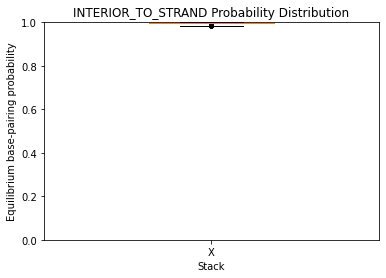

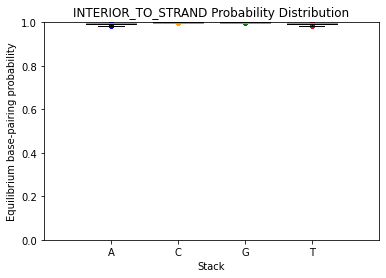

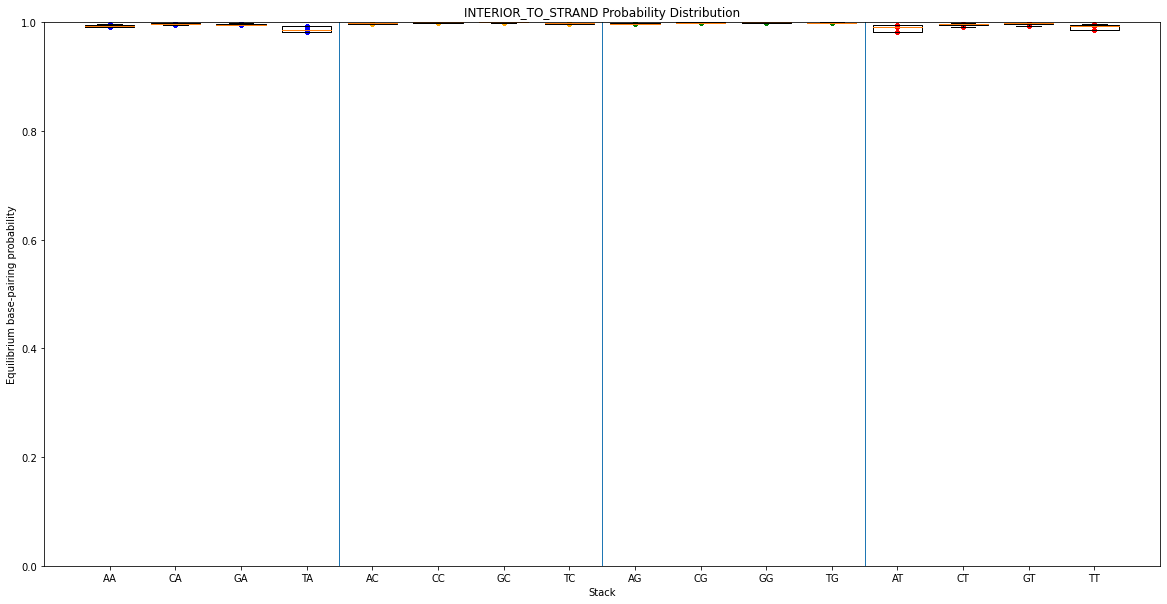

In [16]:
print('INTERIOR_TO_STRAND')
# INTERIOR_TO_STRAND
#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [-----##----->
#                     |||||  |||||
#                    <-----##-----]
#                     |   |  |   |
#                     59 45  44  30
#                       a*^   b*
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['b*', 'a*'], name='bot strand')

interior_to_strand_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 14, 45, 'INTERIOR_TO_STRAND')
summarize_bpps(interior_to_strand_bppr.bpps)
# summarize_bpps_by_base(interior_to_strand_bppr.bpps_by_base)
# summarize_bpps_by_stack(interior_to_strand_bppr.bpps_by_stack)
interior_to_strand_bppr.plot_all()

BLUNT_END
called
validate mismatches set()
DEBUG: Domains to assign: {a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.3480153510747228


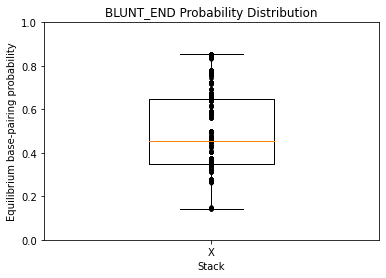

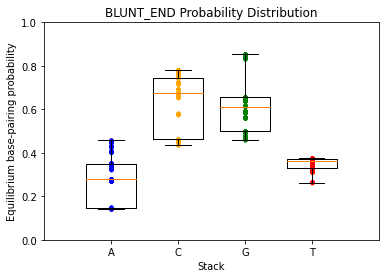

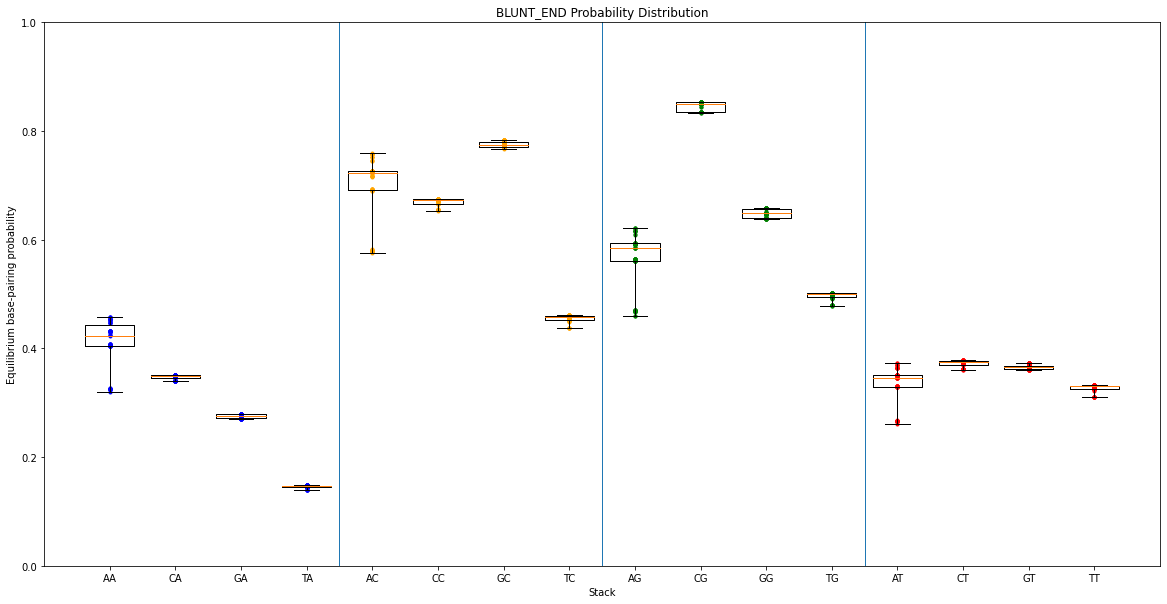

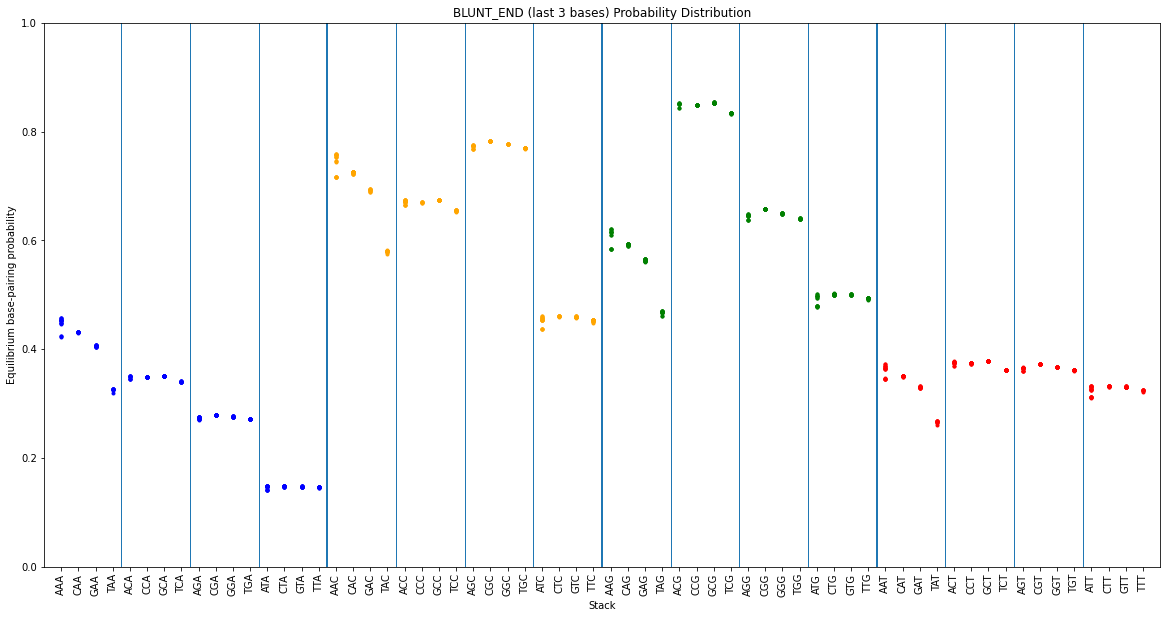

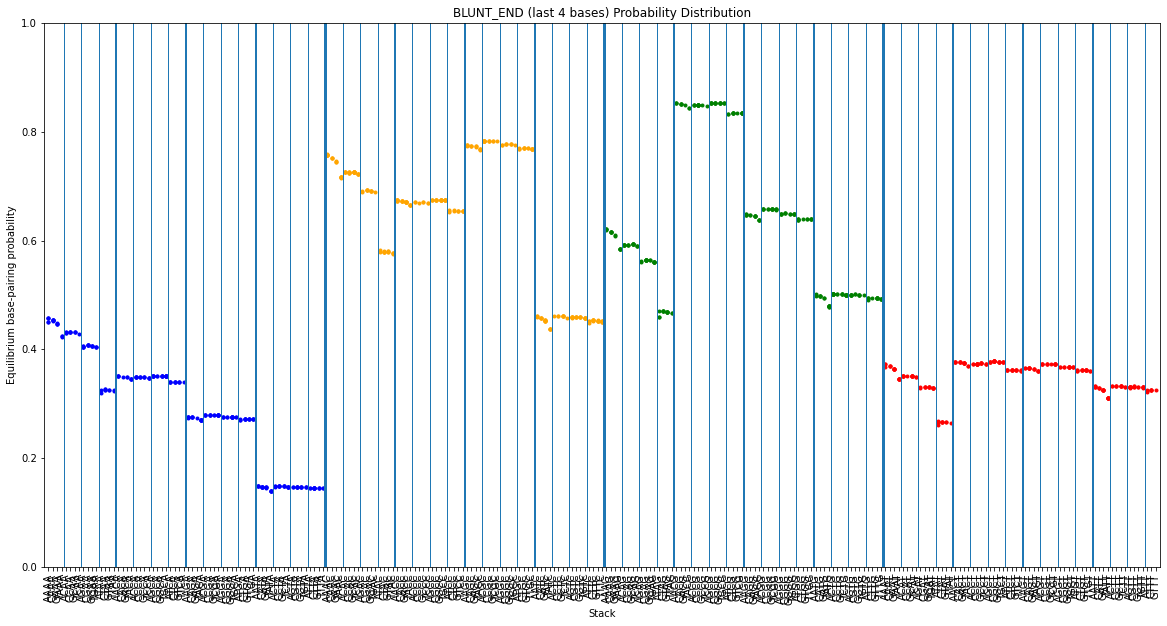

In [53]:
print('BLUNT_END')
#                       a
#                     0  14
#                     |   |
#                    [----->
#                     |||||
#                    <-----]
#                     |   |
#                     29  15
#
#                         ^
#                         |
#                     base pair

top_strand: dc.Strand = dc.Strand(['a'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['a*'], name='bot strand')
    
# Query for last three bases
addresses = [
    StrandBaseAddress(0, 12),
    StrandBaseAddress(0, 13),
    StrandBaseAddress(0, 14),
]
blunt_end_last_three_bases_query = BasePairQuery('BLUNT_END (last 3 bases)', addresses)

# Query for last three bases
addresses = [
    StrandBaseAddress(0, 11),
    StrandBaseAddress(0, 12),
    StrandBaseAddress(0, 13),
    StrandBaseAddress(0, 14),
]
blunt_end_last_four_bases_query = BasePairQuery('BLUNT_END (last 4 bases)', addresses)


blunt_end_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 14, 15, 'BLUNT_END', additional_queries=[blunt_end_last_three_bases_query, blunt_end_last_four_bases_query])
blunt_end_bppr.plot_all()
# summarize_bpps(blunt_end_bpps)
# summarize_bpps_by_base(blunt_end_bpps_by_base)

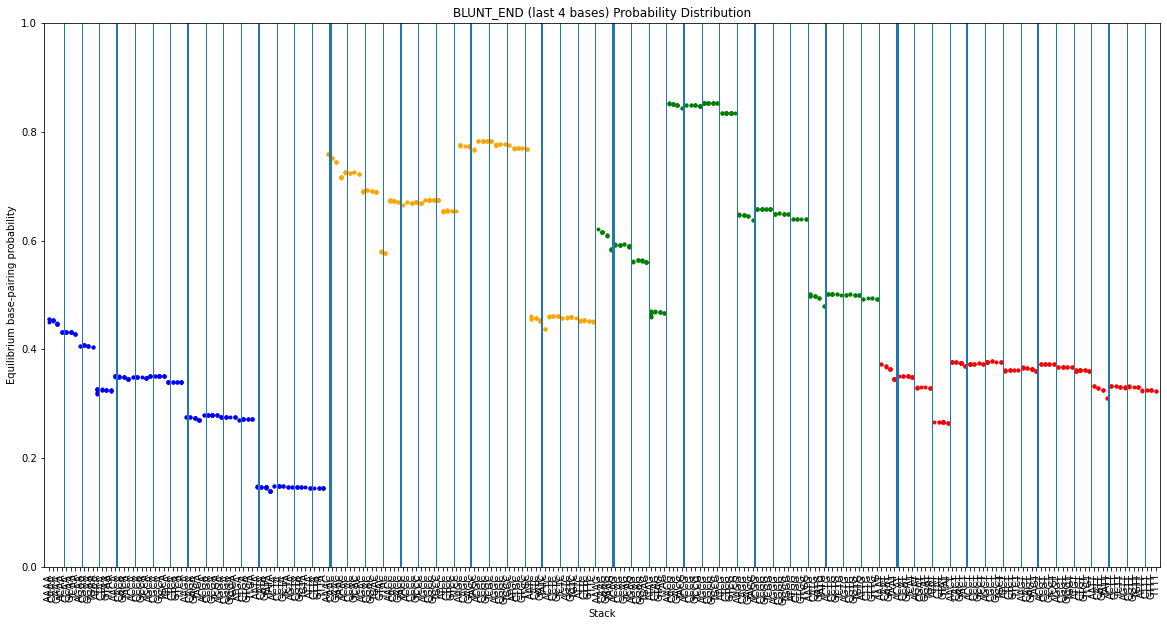

In [50]:
blunt_end_last_four_bases_query.plot()

In [ ]:
print('INTERIOR_ADJACENT_TO_BLUNT_END')
#                       a
#                     0  14
#                     |   |
#                    [----->
#                     |||||
#                    <-----]
#                     |   |
#                     29  15
#
#                         ^
#                         |
#                     base pair

top_strand: dc.Strand = dc.Strand(['a'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['a*'], name='bot strand')

interior_adjacent_to_blunt_end_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 13, 16, 'INTERIOR_ADJACENT_TO_BLUNT_END')
interior_adjacent_to_blunt_end_bppr.plot_all()
for percentile in [25, 50, 75]:
    print(f'{percentile}th Percnetile: {interior_adjacent_to_blunt_end_bppr.percentile(percentile)}')

NICK_3P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.7778564584450914


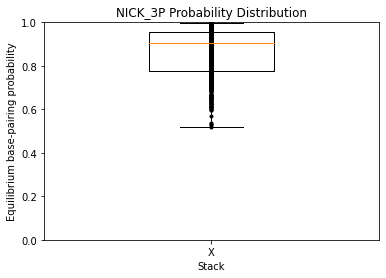

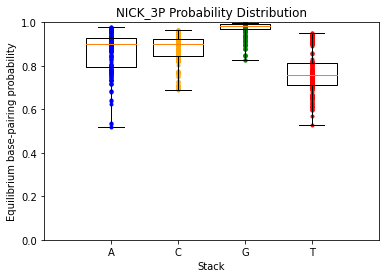

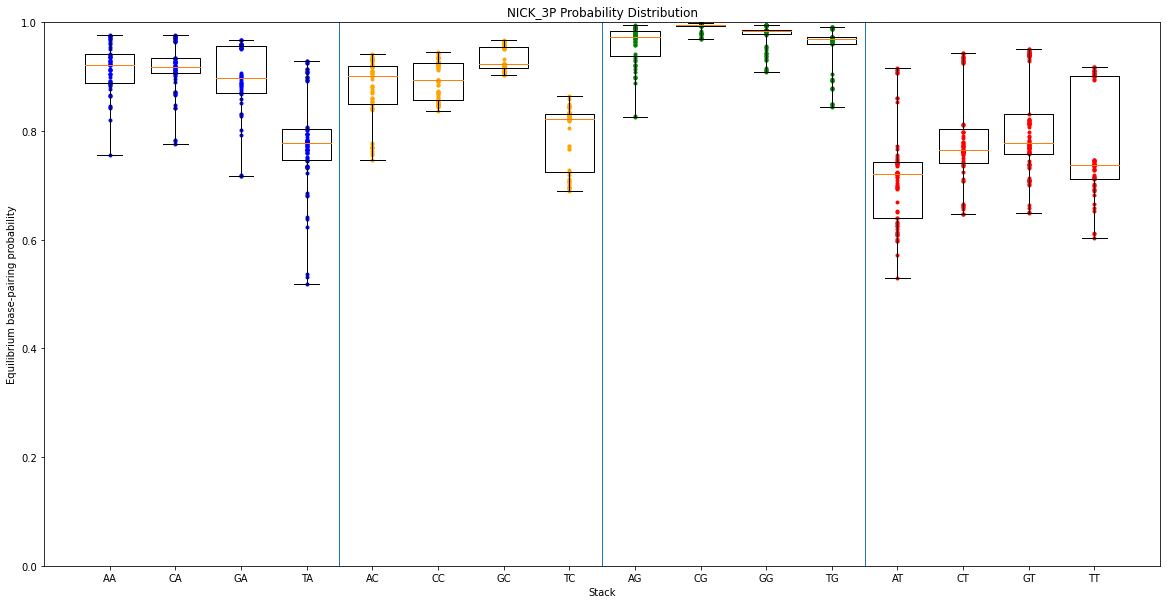

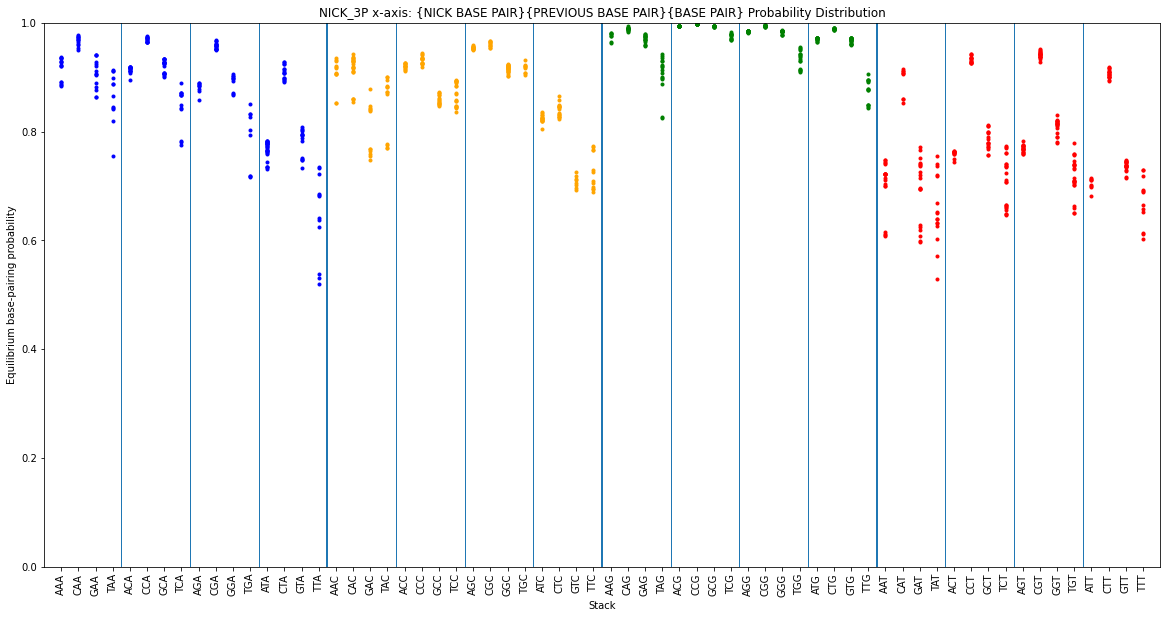

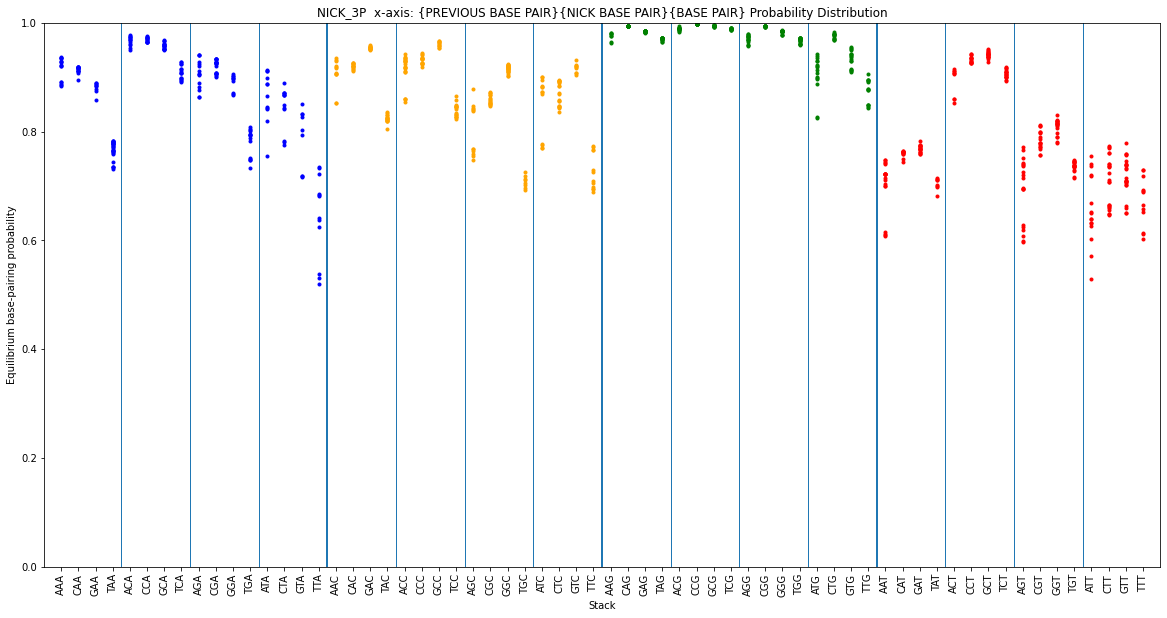

In [5]:
# TODO:
#
# Blunt-end:
#  - base pair 3 away on left

print('NICK_3P')
#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [----->[----->
#                     |||||  |||||
#                    <-----##-----]
#                     |   |  |   |
#                     59 45  44  30
#                       a*    b*
#                         ^
#                         |
#                     base pair
top_strand_left = dc.Strand(['a'], name='top strand left')
top_strand_right = dc.Strand(['b'], name='top strand right')
bot_strand = dc.Strand(['b*', 'a*'], name='bot strand')
strands = (top_strand_left, top_strand_right, bot_strand)

# Get surrounding base pairs
addresses = [
    StrandBaseAddress(1, 0),
    StrandBaseAddress(0, 13),
    StrandBaseAddress(0, 14),
]
query_nick_less_priorty = BasePairQuery('NICK_3P x-axis: {NICK BASE PAIR}{PREVIOUS BASE PAIR}{BASE PAIR}', addresses)

addresses = [
    StrandBaseAddress(0, 13),
    StrandBaseAddress(1, 0),
    StrandBaseAddress(0, 14),
]
query_nick_more_priorty = BasePairQuery('NICK_3P  x-axis: {PREVIOUS BASE PAIR}{NICK BASE PAIR}{BASE PAIR}', addresses)

nick_3p_bppr = nupack_base_pair_probabilities(strands, 14, 45, 'NICK_3P', [query_nick_less_priorty, query_nick_more_priorty])
# summarize_bpps(nick_3p_bpps)
# summarize_bpps_by_base(nick_3p_bpps_by_base)
nick_3p_bppr.plot_all()

# Test if swapping base index leads to consistent results
# Expected: Means and Standard deviations for A and T should swap as should G and C
# nick_3p_bpps, nick_3p_bpps_by_base = nupack_base_pair_probabilities(strands, 45, 14)
# summarize_bpps(nick_3p_bpps)
# summarize_bpps_by_base(nick_3p_bpps_by_base)

# Plot surrounding query
# print('Assuming that previous base pair has greater effect')
# print('x-axis: {NICK BASE PAIR}{PREVIOUS BASE PAIR}{BASE PAIR}')
# nick_3p_surrrounding_base_pairs_query.plot()
# print('Assuming that the nick base pair has greater effect')
# print('x-axis: {PREVIOUS BASE PAIR}{NICK BASE PAIR}{BASE PAIR}')
# nick_3p_surrrounding_base_pairs_query_nick_first.plot()

NICK_5P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.7340523956345693


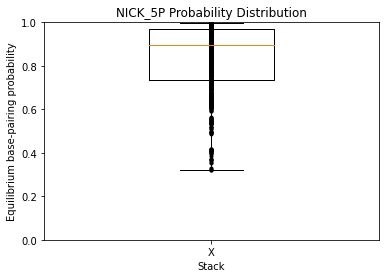

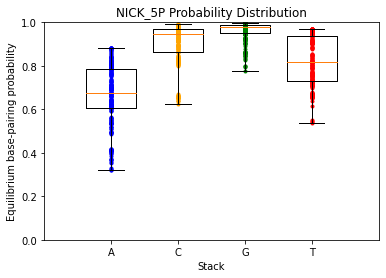

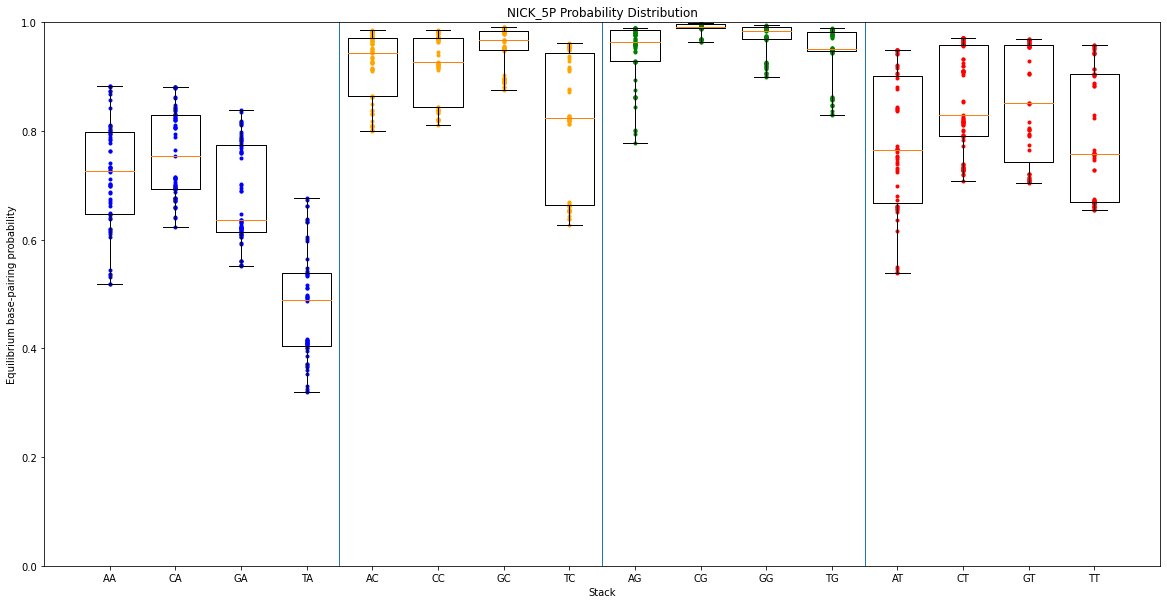

In [6]:
print('NICK_5P')
#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [-----##----->
#                     |||||  |||||
#                    <-----]<-----]
#                     |   |  |   |
#                     59 45  44  30
#                       a*    b*
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand_right: dc.Strand = dc.Strand(['b*'], name='bot strand right')
bot_strand_left: dc.Strand = dc.Strand(['a*'], name='bot strand left')
strands = (top_strand, bot_strand_right, bot_strand_left)

nick_5p_bppr = nupack_base_pair_probabilities(strands, 14, 45, 'NICK_5P')
nick_5p_bppr.plot_all()

DANGLE_3P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.5140252134687404


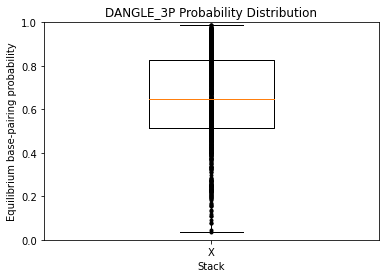

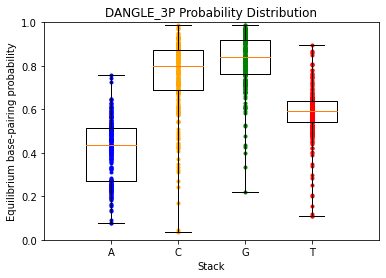

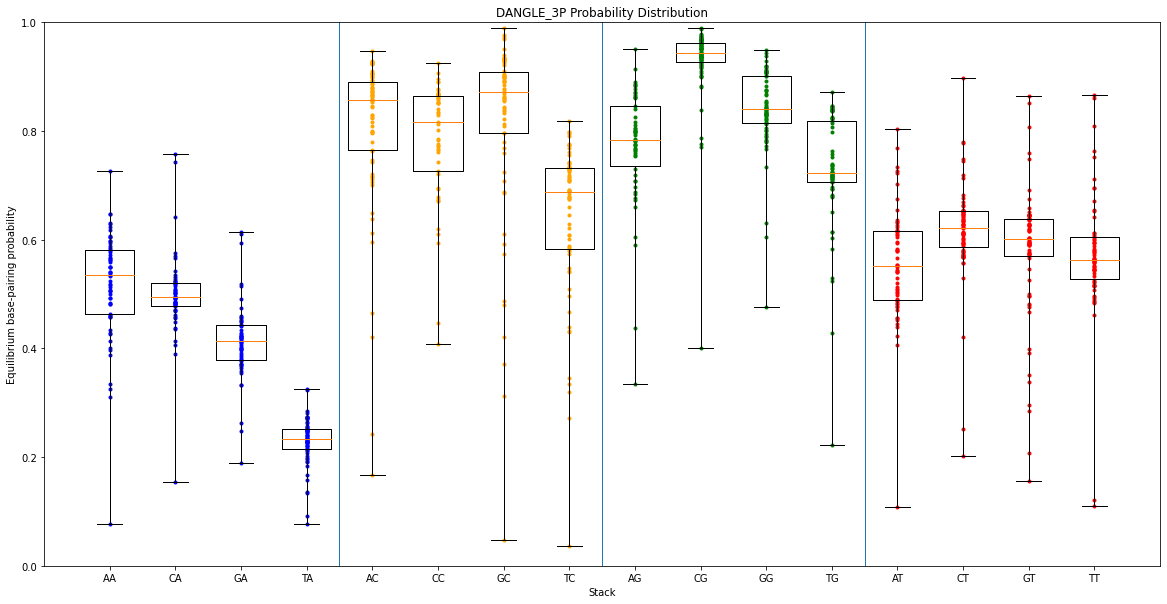

In [7]:
print('DANGLE_3P')
#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [-----##----->
#                     |||||
#                    <-----]
#                     |   |
#                     44 30
#                       a*
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['a*'], name='bot strand')
strands = (top_strand, bot_strand)

dangle_3p_bppr = nupack_base_pair_probabilities(strands, 14, 30, 'DANGLE_3P')
dangle_3p_bppr.plot_all()

DANGLE_5P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.576307674339366


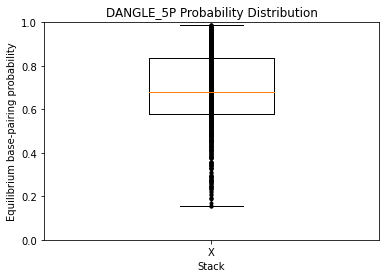

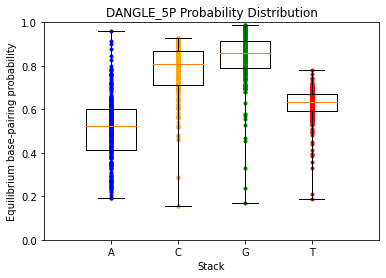

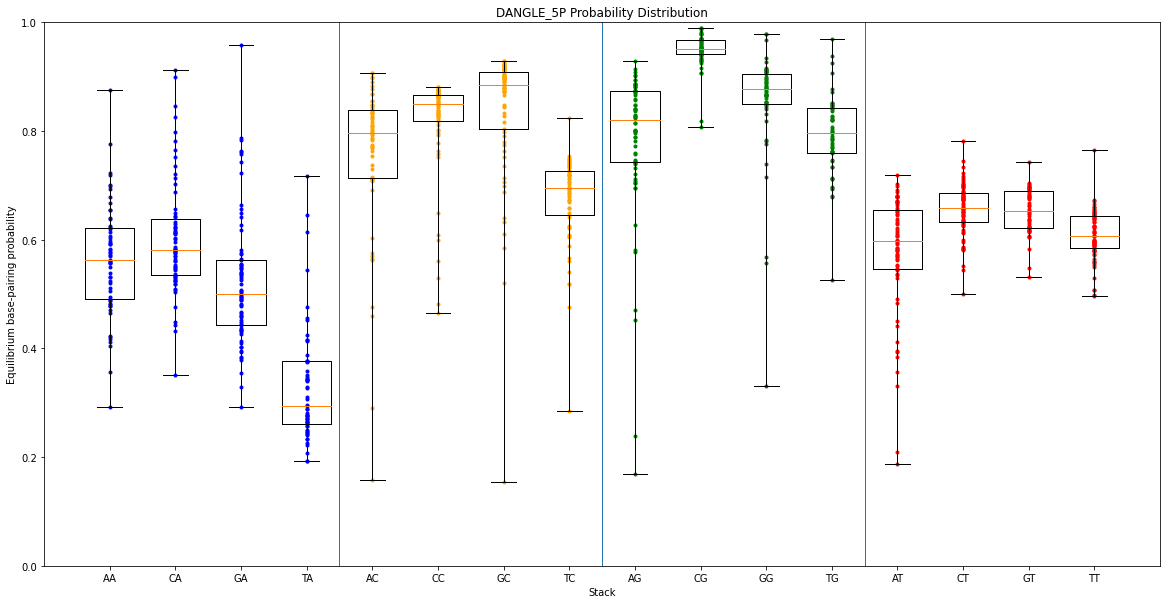

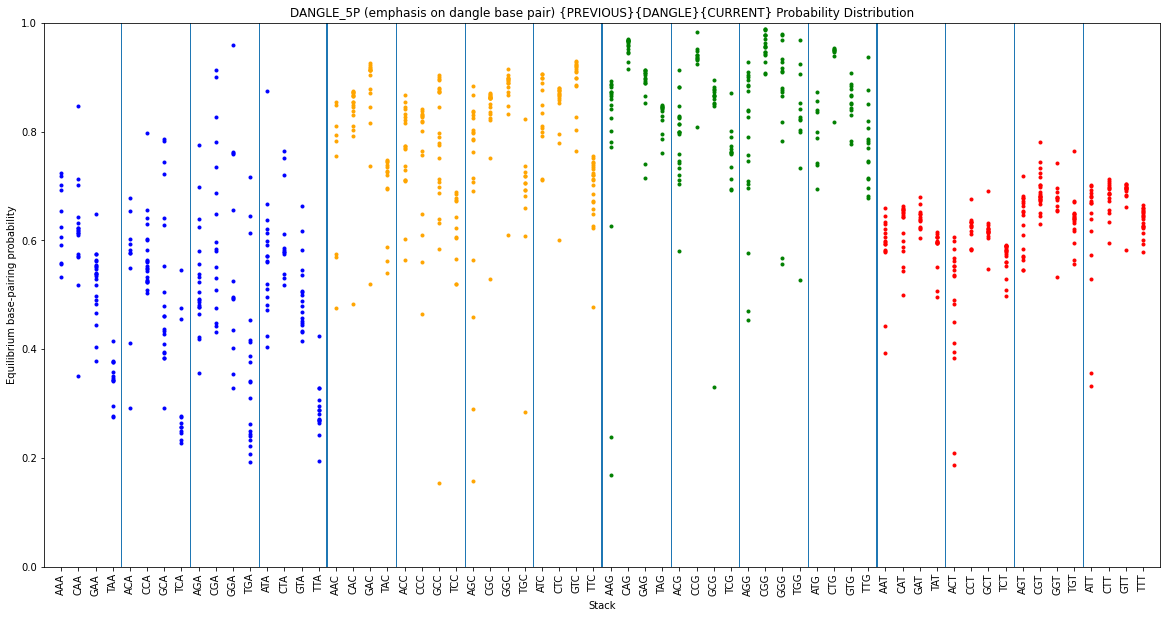

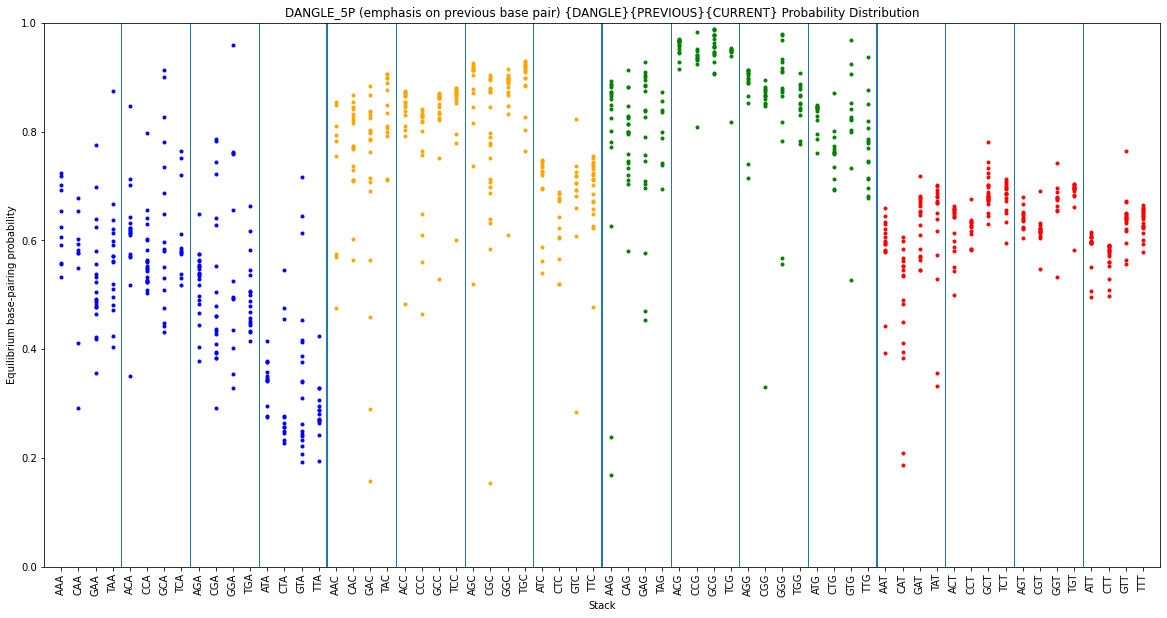

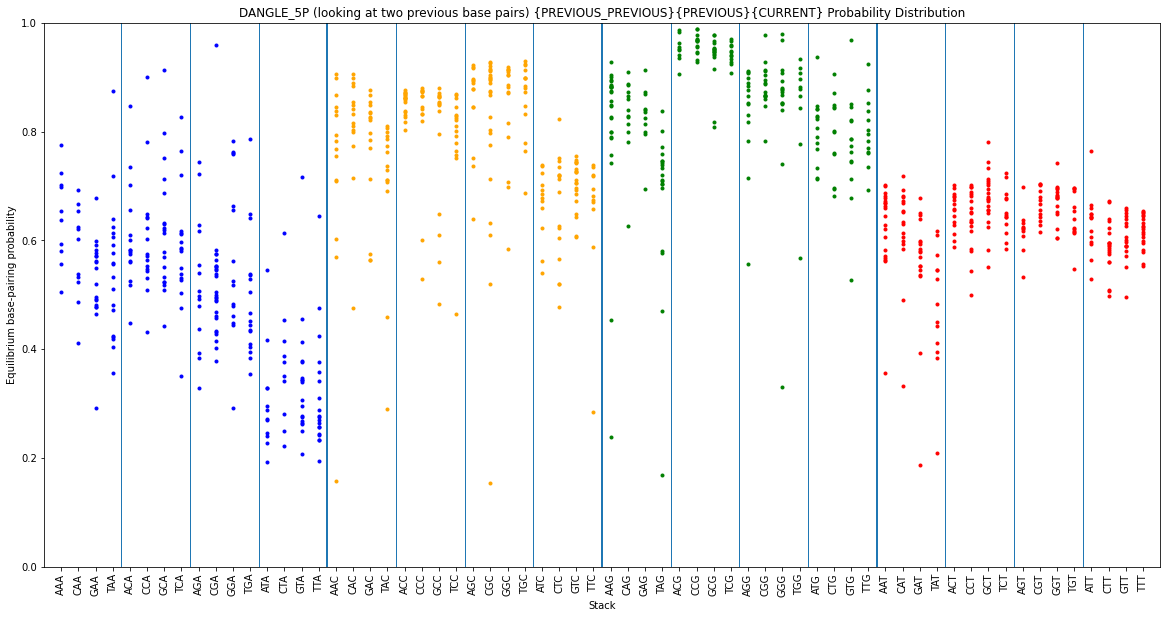

In [8]:
print('DANGLE_5P')
#                       a
#                     0  14
#                     |   |
#                    [----->
#                     |||||
#                    <-----##-----]
#                     |   |  |   |
#                     44 30  29  15
#                           1.14 1.0 <- strand base addresses
#                       a*    b*
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['b*', 'a*'], name='bot strand')
strands = (top_strand, bot_strand)

# Additional query
query_dangle_first = BasePairQuery('DANGLE_5P (emphasis on dangle base pair) {PREVIOUS}{DANGLE}{CURRENT}', [
    StrandBaseAddress(0, 13),
    StrandBaseAddress(1, 14),
    StrandBaseAddress(0, 14)
])
query_dangle_last = BasePairQuery('DANGLE_5P (emphasis on previous base pair) {DANGLE}{PREVIOUS}{CURRENT}', [
    StrandBaseAddress(1, 14),
    StrandBaseAddress(0, 13),
    StrandBaseAddress(0, 14)
])
query_previous_base_pairs = BasePairQuery('DANGLE_5P (looking at two previous base pairs) {PREVIOUS_PREVIOUS}{PREVIOUS}{CURRENT}', [
    StrandBaseAddress(0, 12),
    StrandBaseAddress(0, 13),
    StrandBaseAddress(0, 14)
])
dangle_5p_bppr = nupack_base_pair_probabilities(strands, 14, 30, 'DANGLE_5P', [query_dangle_first, query_dangle_last, query_previous_base_pairs])
dangle_5p_bppr.plot_all()
# summarize_bpps(dangle_5p_bpps)
# summarize_bpps_by_base(dangle_5p_bpps_by_base)

INTERIOR_BEFORE_A_DANGLE_5P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 13
Upper quartile: 0.9841486771756809
Lower Quartile Probability: 0.9041947017163311


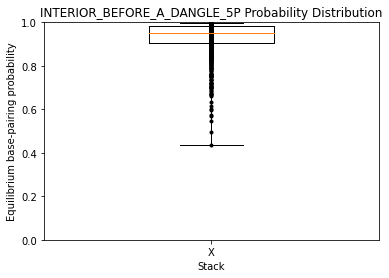

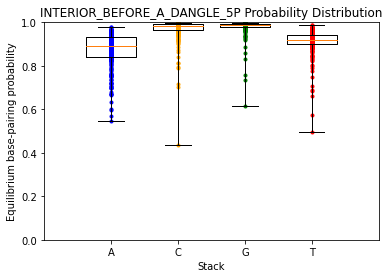

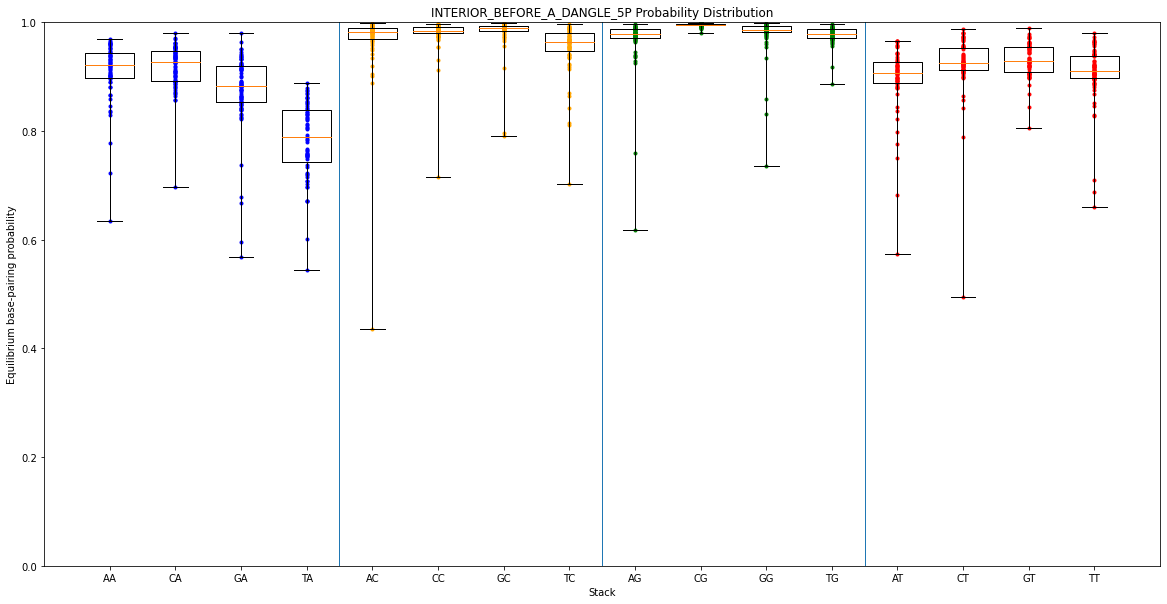

In [9]:
print('INTERIOR_BEFORE_A_DANGLE_5P')
#                       a
#                     0  14
#                     |   |
#                    [----->
#                     |||||
#                    <-----##-----]
#                     |   |  |   |
#                     44 30  29  15
#                           1.14 1.0 <- strand base addresses
#                       a*    b*
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['b*', 'a*'], name='bot strand')
strands = (top_strand, bot_strand)

interior_before_dangle_5p = nupack_base_pair_probabilities(strands, 13, 31, 'INTERIOR_BEFORE_A_DANGLE_5P')
print(f'Upper quartile: {interior_before_dangle_5p.upper_quartile()}')
interior_before_dangle_5p.plot_all()
# summarize_bpps(dangle_5p_bpps)
# summarize_bpps_by_base(dangle_5p_bpps_by_base)

INTERIOR_TWO_BEFORE_A_DANGLE_5P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 12
Lower Quartile Probability: 0.9817283046890626


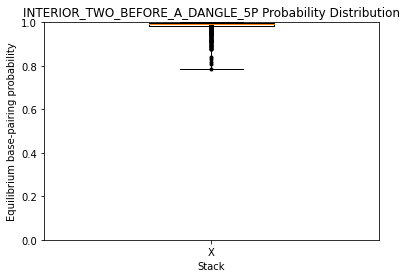

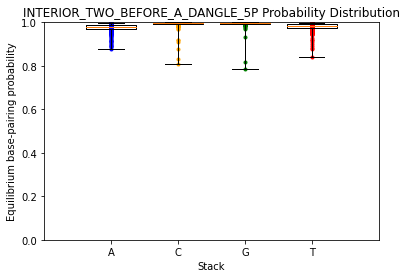

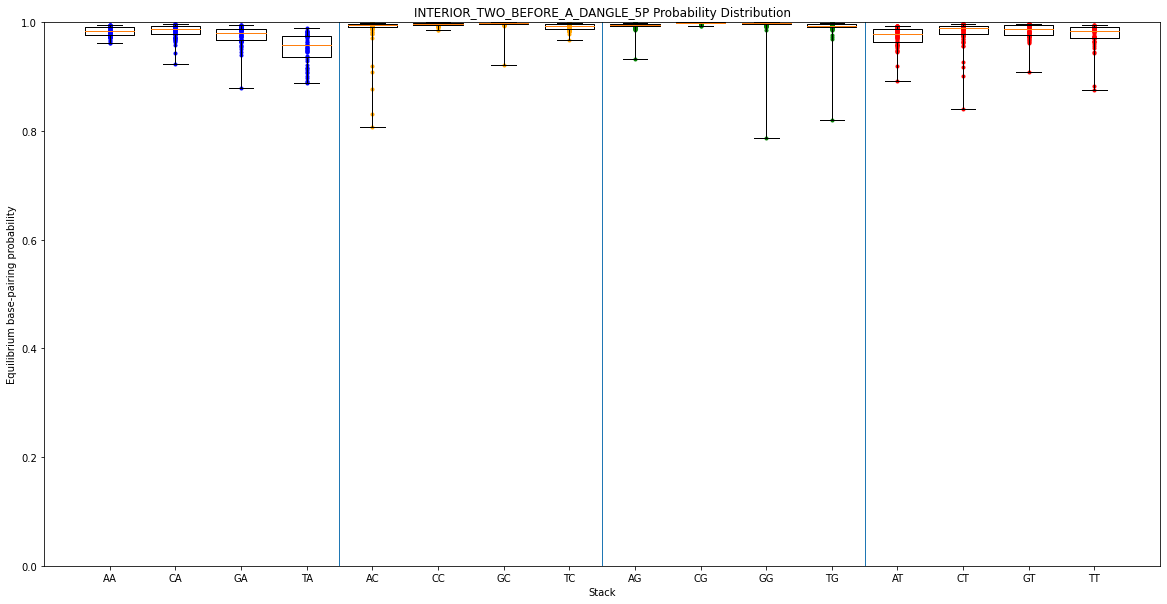

In [10]:
print('INTERIOR_TWO_BEFORE_A_DANGLE_5P')
#                       a
#                     0  14
#                     |   |
#                    [----->
#                     |||||
#                    <-----##-----]
#                     |   |  |   |
#                     44 30  29  15
#                           1.14 1.0 <- strand base addresses
#                       a*    b*
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['b*', 'a*'], name='bot strand')
strands = (top_strand, bot_strand)

interior_two_before_dangle_5p = nupack_base_pair_probabilities(strands, 12, 32, 'INTERIOR_TWO_BEFORE_A_DANGLE_5P')
interior_two_before_dangle_5p.plot_all()

INTERIOR_THREE_BEFORE_A_DANGLE_5P
DEBUG: Domains to assign: {b, a}
DEBUG: Using strand index 0 and base index 11
Lower Quartile Probability: 0.9916750626310642


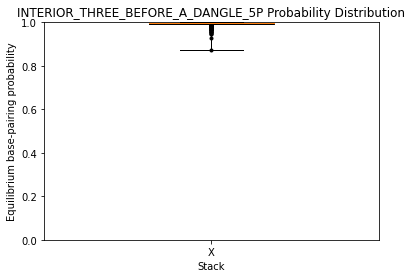

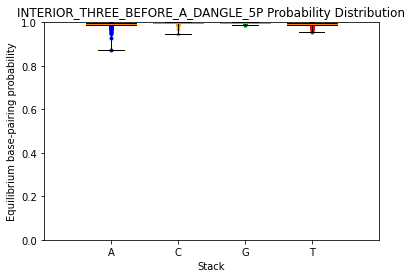

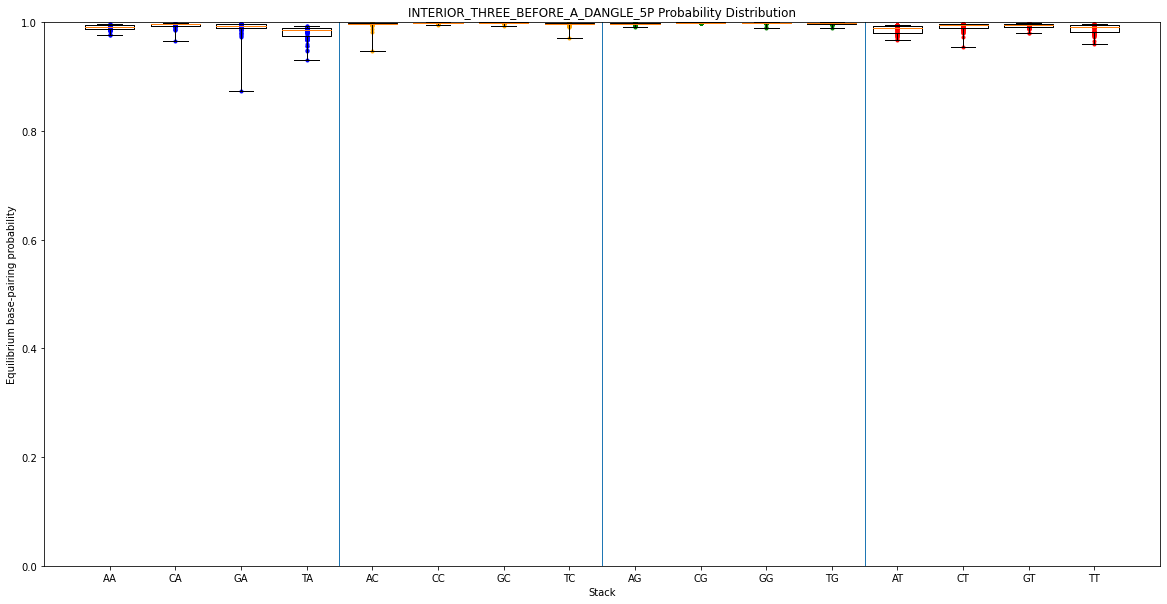

In [11]:
print('INTERIOR_THREE_BEFORE_A_DANGLE_5P')
#                       a
#                     0  14
#                     |   |
#                    [----->
#                     |||||
#                    <-----##-----]
#                     |   |  |   |
#                     44 30  29  15
#                           1.14 1.0 <- strand base addresses
#                       a*    b*
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['b*', 'a*'], name='bot strand')
strands = (top_strand, bot_strand)

interior_three_before_dangle_5p = nupack_base_pair_probabilities(strands, 11, 33, 'INTERIOR_THREE_BEFORE_A_DANGLE_5P')
interior_three_before_dangle_5p.plot_all()

DANGLE_5P_3P
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.6595399424495325


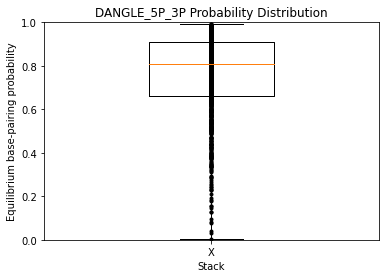

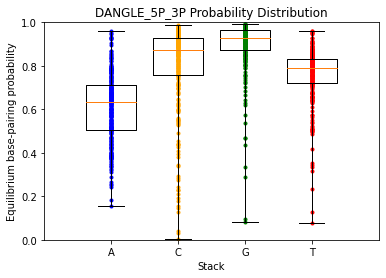

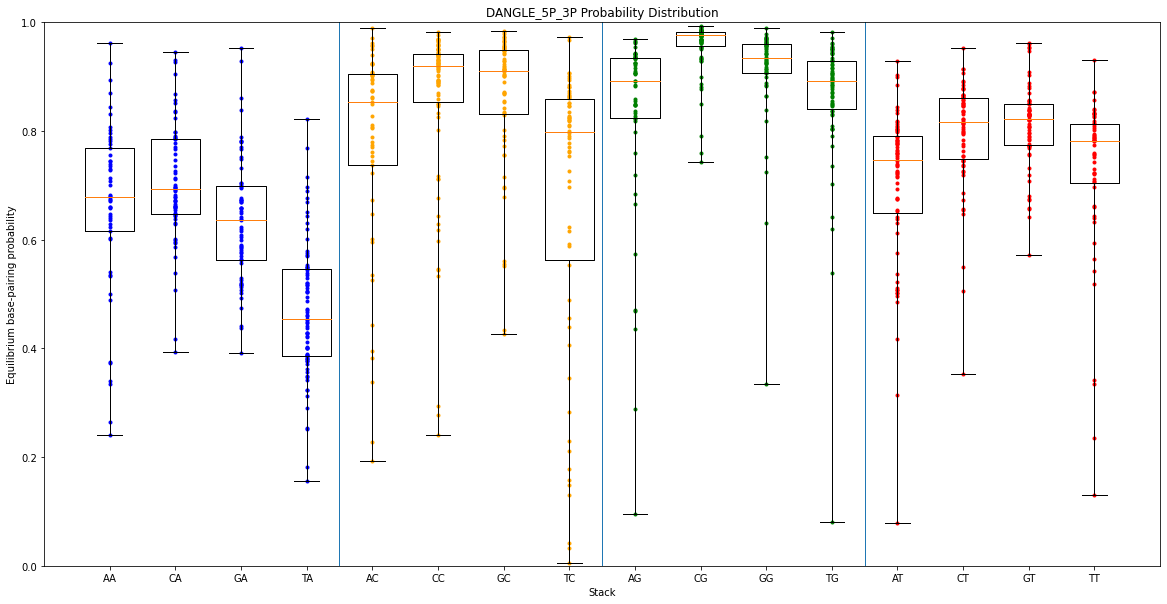

In [37]:
# TODO:
# Single stranded, make it all Ts and all Cs
# Random sequence subject 

# TODO:
# Overhang of lenth 1 vs overhang of length 15

print('DANGLE_5P_3P')
#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [-----##----->
#                         G
#                     |||||
#                         C
#                    <-----##-----]
#                     |   |  |   |
#                     59 45  44  30
#                       a*    c
#                         ^
#                         |
#                     base pair

#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [-----##----->
#                         C
#                     |||||
#                         G
#                    <-----##-----]
#                     |   |  |   |
#                     59 45  44  30
#                       a*    c
#                         ^
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['c', 'a*'], name='bot strand')
strands = (top_strand, bot_strand)

# TODO: How many mismatches are needed for dangle?
mismatches = [
    (StrandBaseAddress(0,15), StrandBaseAddress(1,14)),
    (StrandBaseAddress(0,16), StrandBaseAddress(1,13)),
    (StrandBaseAddress(0,17), StrandBaseAddress(1,12)),
    (StrandBaseAddress(0,18), StrandBaseAddress(1,11)),
    (StrandBaseAddress(0,19), StrandBaseAddress(1,10)),

]

dangle_5p_3p_bppr = nupack_base_pair_probabilities(strands, 14, 45, 'DANGLE_5P_3P', mismatches=mismatches)
dangle_5p_3p_bppr.plot_all()

OVERHANG_ON_THIS_STRAND_3P
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.8216758951353232


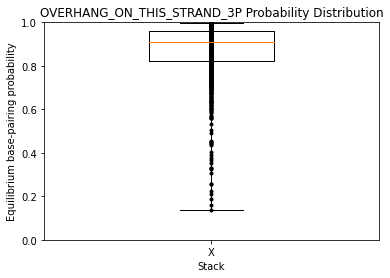

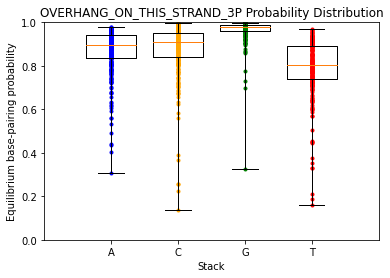

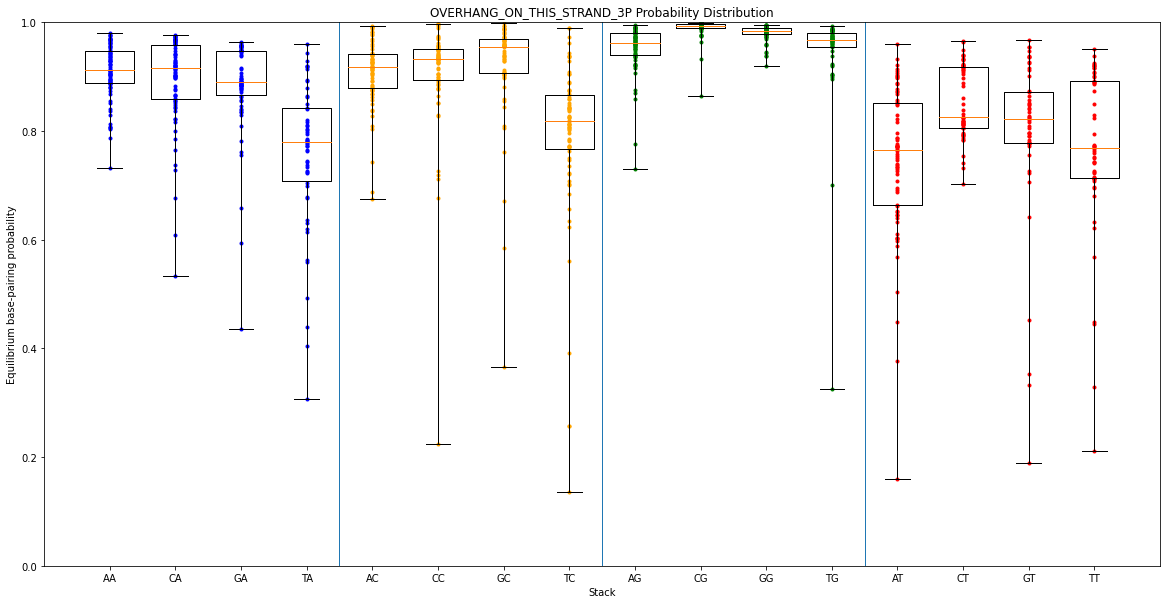

In [13]:
print('OVERHANG_ON_THIS_STRAND_3P')
#                          ^
#                          |-29
#                          |   b
#                          |-15
#                          #
#                          #
#                       a  #    c
#                     0  14#  30  44
#                     |   |#  |   |
#                    [-----# [----->
#                     |||||   |||||
#                    <-----###-----]
#                     |   |   |   |
#                     74  60  59  45
#                       a*      c*
#                         ^
#                         |
#                     base pair
top_strand_left: dc.Strand = dc.Strand(['a', 'b'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['c'], name='top strand right')
bot_strand: dc.Strand = dc.Strand(['c*', 'a*'], name='bot strand')
strands = (top_strand_left, top_strand_right, bot_strand)

overhang_on_this_strand_3p_bppr = nupack_base_pair_probabilities(strands, 14, 60, 'OVERHANG_ON_THIS_STRAND_3P')
overhang_on_this_strand_3p_bppr.plot_all()

OVERHANG_ON_THIS_STRAND_3P (overhang, length 1)
called
validate mismatches set()
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.8745061687313266


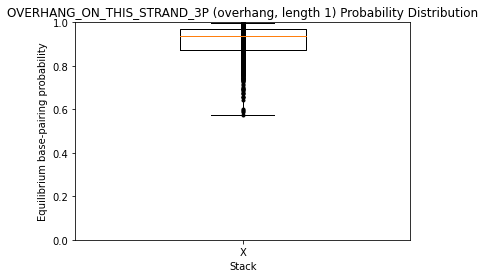

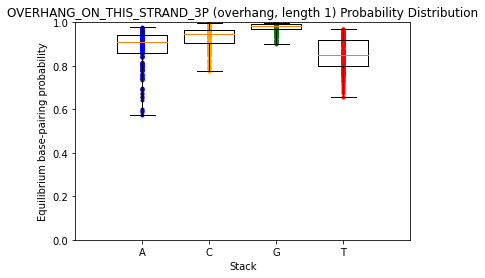

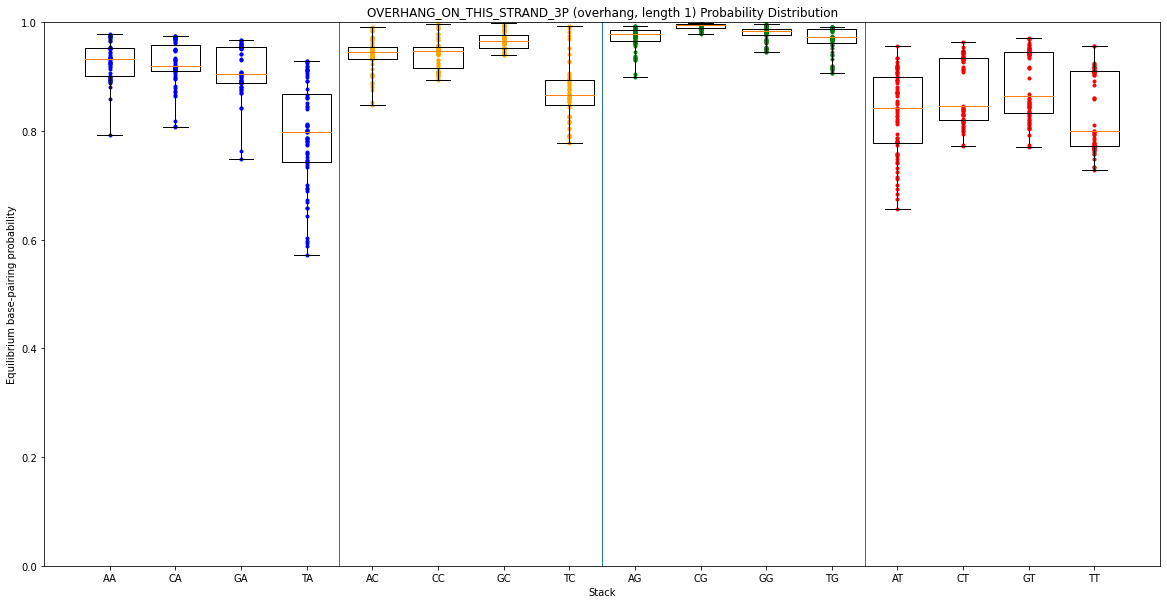

In [7]:



print('OVERHANG_ON_THIS_STRAND_3P (overhang, length 1)')
#                          ^   
#                          |-15 b
#                          #
#                          #
#                       a  #    c
#                     0  14#  16  30
#                     |   |#  |   |
#                    [-----# [----->
#                     |||||   |||||
#                    <-----###-----]
#                     |   |   |   |
#                     60  46  45  31
#                       a*      c*
#                         ^
#                         |
#                     base pair
top_strand_left: dc.Strand = dc.Strand(['a', 'b'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['c'], name='top strand right')
bot_strand: dc.Strand = dc.Strand(['c*', 'a*'], name='bot strand')
strands = (top_strand_left, top_strand_right, bot_strand)

pool_15 = dc.DomainPool('pool 15', 15)
pool_overhang = dc.DomainPool('pool overhang', 1)
top_strand_left.domains[0].pool = pool_15
top_strand_left.domains[1].pool = pool_overhang
top_strand_right.domains[0].pool = pool_15

bot_strand.domains[0].pool = pool_15
bot_strand.domains[1].pool = pool_15


overhang_on_this_strand_3p_bppr = nupack_base_pair_probabilities(strands, 14, 46, 'OVERHANG_ON_THIS_STRAND_3P (overhang, length 1)', skip_domain_pool_setup=True)
overhang_on_this_strand_3p_bppr.plot_all()

OVERHANG_ON_THIS_STRAND_5P
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.7857204732565986


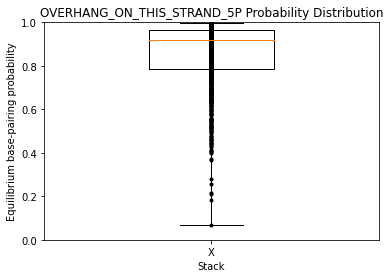

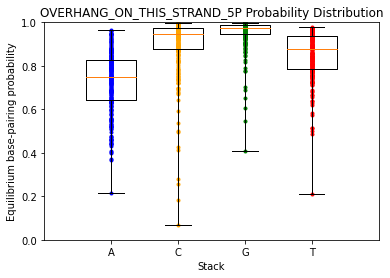

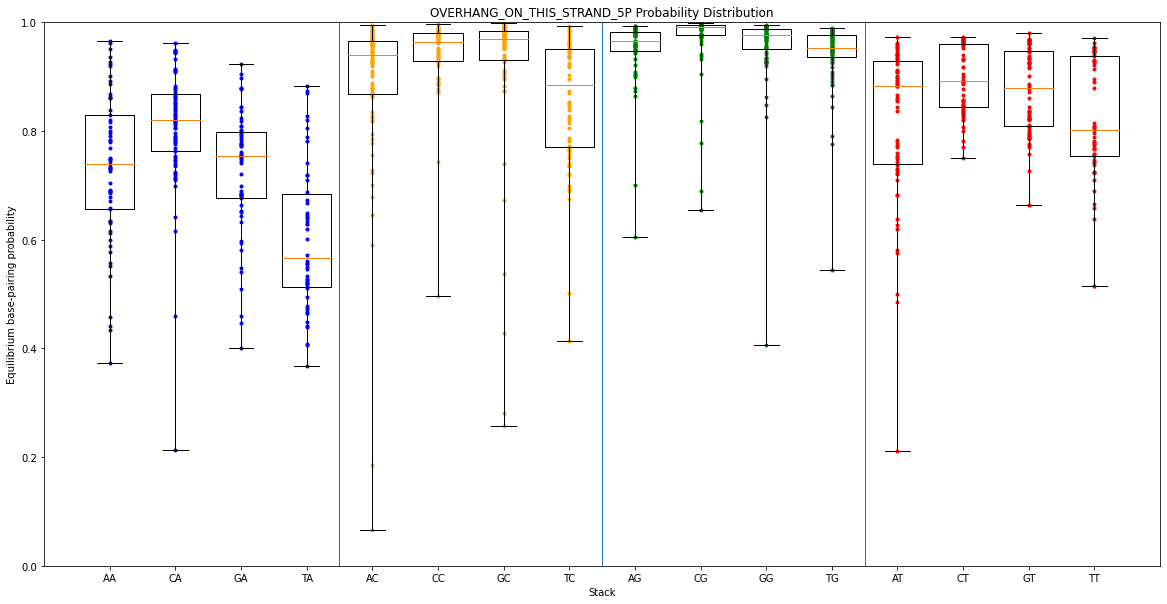

In [14]:
print('OVERHANG_ON_THIS_STRAND_5P')
#                     base pair
#                         |
#                         v
#                       a       b
#                     0   14  15  29
#                     |   |   |   |
#                    [-----###----->
#                     |||||   |||||
#                    <-----# <-----]
#                     |   |#  |   |
#                     74 60#  44  30
#                       a* #    b*
#                          #
#                          #
#                          |-59
#                          |    c
#                          |-45
#                          ]
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand_right: dc.Strand = dc.Strand(['b*'], name='bot strand right')
bot_strand_left: dc.Strand = dc.Strand(['c', 'a*'], name='bot strand left')
strands = (top_strand, bot_strand_right, bot_strand_left)

overhang_on_this_strand_5p_bppr = nupack_base_pair_probabilities(strands, 14, 60, 'OVERHANG_ON_THIS_STRAND_5P')
overhang_on_this_strand_5p_bppr.plot_all()

OVERHANG_ON_ADJACENT_STRAND_3P
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.5529997506617841


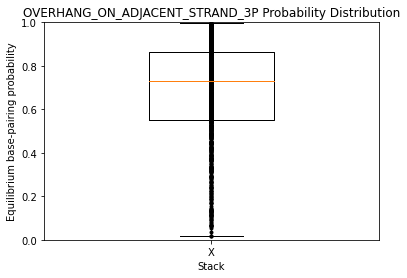

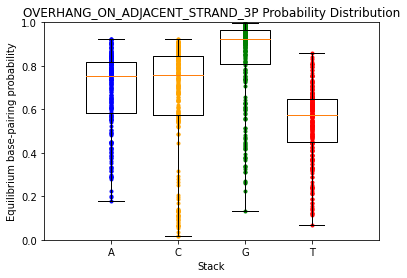

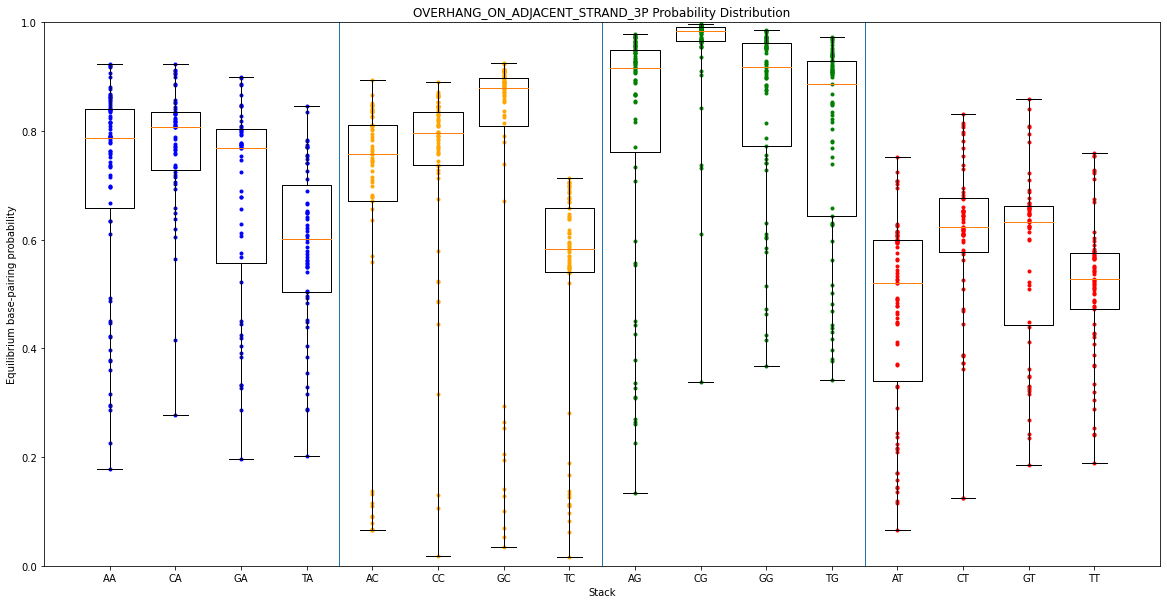

In [15]:
print('OVERHANG_ON_ADJACENT_STRAND_3P')
#                            [
#                            |-15
#                            |    b
#                            |-29
#                            #
#                            #
#                       a    #  c
#                     0   14 #30  44
#                     |   |  #|   |      
#                    [-----> #----->
#                     |||||   |||||
#                    <-----###-----]
#                     |   |   |   |
#                     74  60  59  45
#                       a*      c*
#                         ^
#                         |
#                     base pair
top_strand_left: dc.Strand = dc.Strand(['a'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['b', 'c'], name='top strand right')
bot_strand: dc.Strand = dc.Strand(['c*', 'a*'], name='bot strand')
strands = (top_strand_left, top_strand_right, bot_strand)

overhang_on_adj_strand_3p_bppr = nupack_base_pair_probabilities(strands, 14, 60, 'OVERHANG_ON_ADJACENT_STRAND_3P')
overhang_on_adj_strand_3p_bppr.plot_all()

In [16]:
print('OVERHANG_ON_ADJACENT_STRAND_5P')
#                     base pair
#                         |
#                         v
#                       a       b
#                     0   14  15  29
#                     |   |   |   |   
#                    [-----###----->
#                     |||||   |||||
#                    <-----] #-----]
#                     |   |  #|   |
#                     74  60 #44  30
#                       a*   #  b*
#                            #
#                            #
#                            |-45
#                            |   c 
#                            |-59
#                            v
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand_right: dc.Strand = dc.Strand(['b*', 'c'], name='bot strand right')
bot_strand_left: dc.Strand = dc.Strand(['a*'], name='bot strand left')
strands = (top_strand, bot_strand_right, bot_strand_left)

overhang_on_adj_strand_5p_bppr = nupack_base_pair_probabilities(strands, 14, 60, 'OVERHANG_ON_ADJACENT_STRAND_5P')

OVERHANG_ON_ADJACENT_STRAND_5P
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14


OVERHANG_ON_BOTH_STRAND_3P
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.6106737955587055


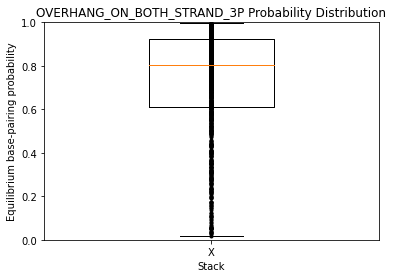

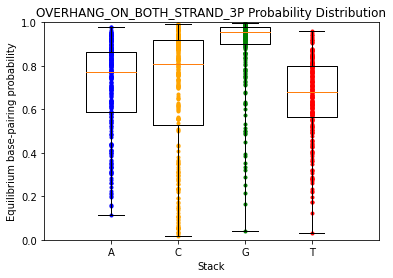

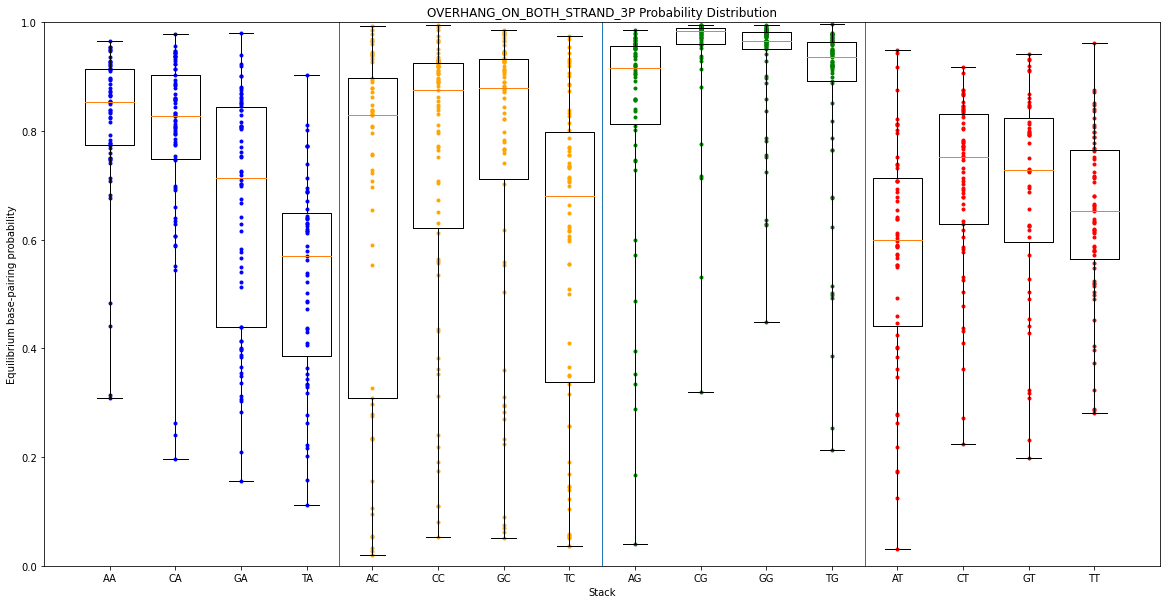

In [17]:
print('OVERHANG_ON_BOTH_STRAND_3P')
#                          ^ [
#                       29-| |-30
#                     b    | |    c
#                       15-| |-44
#                          # #
#                       a  # #   d
#                     0  14# #45  59
#                     |   |   |   |
#                    [-----# #----->
#                     |||||   |||||
#                    <-----###-----]
#                     |   |   |   |
#                     89 75   74  60
#                       a*      d*
#                         ^
#                         |
#                     base pair
top_strand_left: dc.Strand = dc.Strand(['a', 'b'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['c', 'd'], name='top strand right')
bot_strand: dc.Strand = dc.Strand(['d*', 'a*'], name='bot strand')
strands = (top_strand_left, top_strand_right, bot_strand)

overhang_on_both_strand_3p_bppr = nupack_base_pair_probabilities(strands, 14, 75, 'OVERHANG_ON_BOTH_STRAND_3P')
overhang_on_both_strand_3p_bppr.plot_all()

OVERHANG_ON_BOTH_STRAND_5P
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.5998478503534908


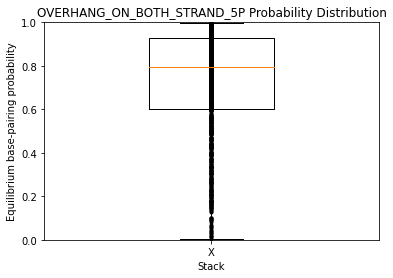

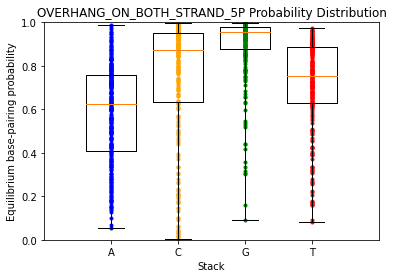

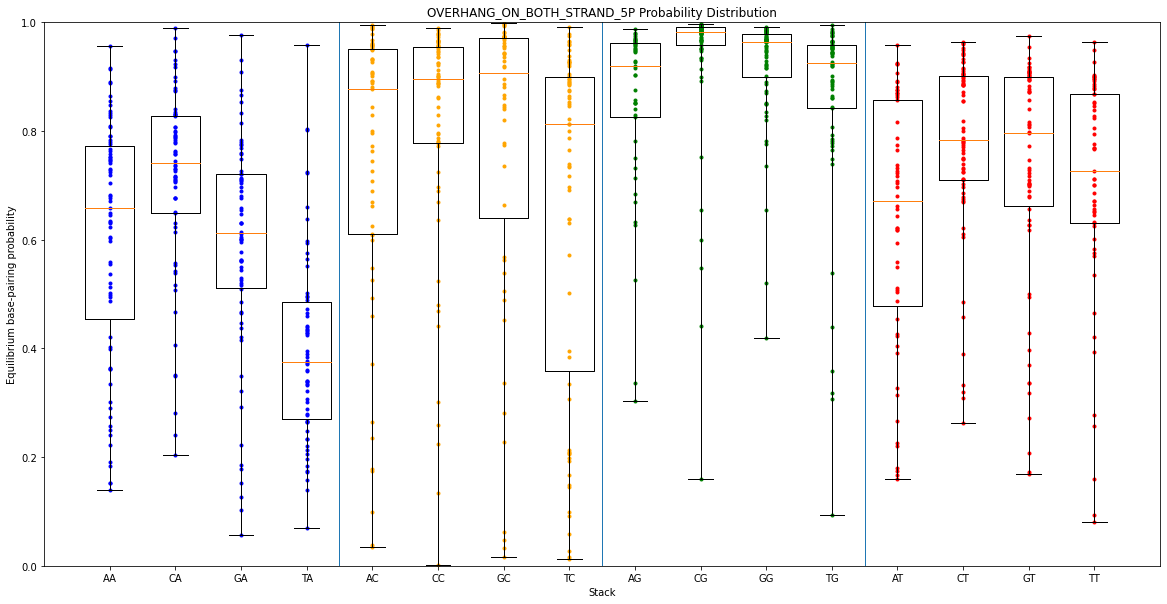

In [18]:
print('OVERHANG_ON_BOTH_STRAND_5P')
#
#
#                     base pair
#                         |
#                         v
#                       a       b
#                     0   14  15  29
#                     |   |   |   |   
#                    [-----###----->
#                     |||||   |||||
#                    <-----# #-----]
#                     |   |# #|   |
#                     89 75# #44  30
#                       a* # #  b*
#                          # #
#                          # #
#                       74-| |-45
#                      d   | |   c
#                       60-| |-59
#                          ] v
top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand_right: dc.Strand = dc.Strand(['b*', 'c'], name='bot strand right')
bot_strand_left: dc.Strand = dc.Strand(['d', 'a*'], name='bot strand left')
strands = (top_strand, bot_strand_right, bot_strand_left)

overhang_on_both_strand_5p_bppr = nupack_base_pair_probabilities(strands, 14, 75, 'OVERHANG_ON_BOTH_STRAND_5P')
overhang_on_both_strand_5p_bppr.plot_all()

THREE_ARM_JUNCTION
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.691782483211537


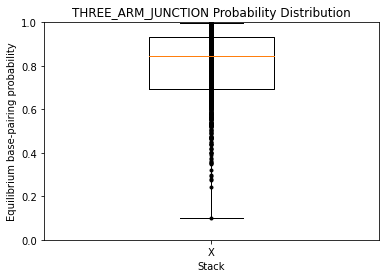

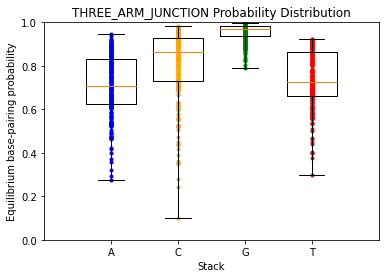

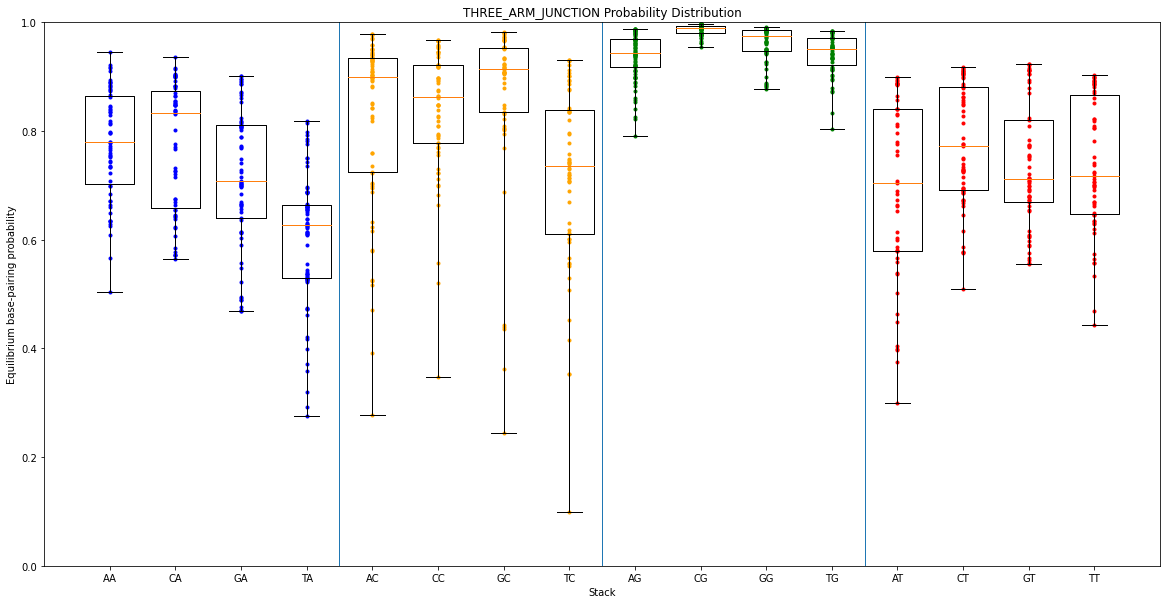

In [19]:
print('THREE_ARM_JUNCTION')
#                          ^ [
#                       29-|-|-30
#                     b    |-|    b*
#                       15-|-|-44
#                          # #
#                       a  # #   c
#                     0  14# #45  59
#                     |   |   |   |
#                    [-----# #----->
#                     |||||   |||||
#                    <-----###-----]
#                     |   |   |   |
#                     89 75   74  60
#                       a*      c*
#                         ^
#                         |
#                     base pair
top_strand_left: dc.Strand = dc.Strand(['a', 'b'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['b*', 'c'], name='top strand right')
bot_strand: dc.Strand = dc.Strand(['c*', 'a*'], name='bot strand')
strands = (top_strand_left, top_strand_right, bot_strand)

three_arm_junction_bppr = nupack_base_pair_probabilities(strands, 14, 75, 'THREE_ARM_JUNCTION')
three_arm_junction_bppr.plot_all()

FOUR_ARM_JUNCTION
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.8425505755389837


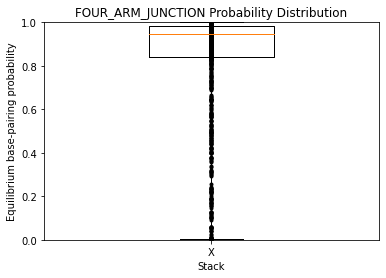

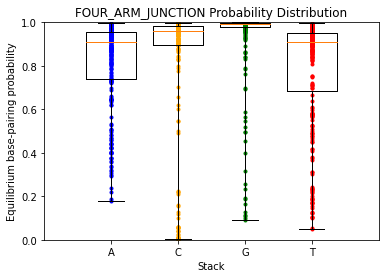

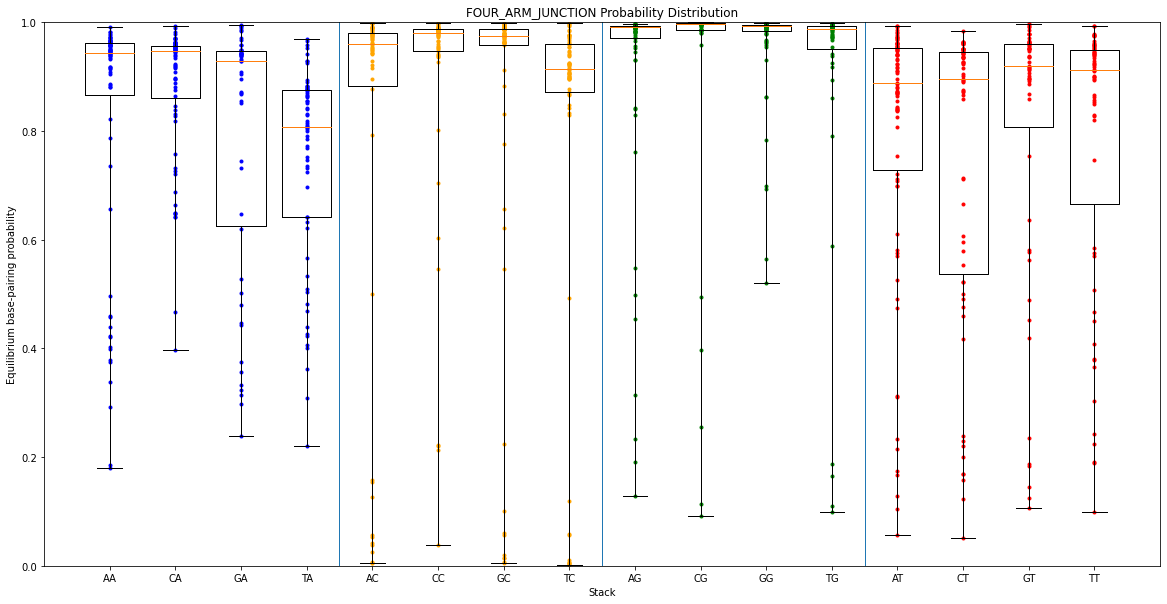

In [20]:
print('FOUR_ARM_JUNCTION')
#                          ^ [
#                       29-|-|-30
#                      b   |-|   b*
#                       15-|-|-44
#                          # #
#                          # #
#                       a  # #  c
#                     0  14# #45  59
#                     |   |# #|   |
#                    [-----# #----->
#                     |||||   |||||
#                    <-----# #-----]
#                     |   |# #|   |
#                   120 105# #74  60
#                      a*  # #  c*
#                          # #
#                          # #
#                      104-|-|-75
#                     d*   |-|    d
#                       90-|-|-89
#                          ] v
top_strand_left: dc.Strand = dc.Strand(['a', 'b'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['b*', 'c'], name='top strand right')
bot_strand_right: dc.Strand = dc.Strand(['c*', 'd'], name='bot strand right')
bot_strand_left: dc.Strand = dc.Strand(['d*', 'a*'], name='bot strand left')
strands = (top_strand_left, top_strand_right, bot_strand_right, bot_strand_left)

four_arm_junction_bppr = nupack_base_pair_probabilities(strands, 14, 105, 'FOUR_ARM_JUNCTION')
four_arm_junction_bppr.plot_all()

# Code below was is remant code for trying symmetrical situations to test for validity of simulation
# summarize_bpps(four_arm_junction_bpps)
# summarize_bpps_by_base(four_arm_junction_bpps_by_base)

# print('------------------------------------------------')

# four_arm_junction_bpps, four_arm_junction_bpps_by_base = nupack_base_pair_probabilities(strands, 44, 15)
# summarize_bpps(four_arm_junction_bpps)
# summarize_bpps_by_base(four_arm_junction_bpps_by_base)

# print('------------------------------------------------')

# four_arm_junction_bpps, four_arm_junction_bpps_by_base = nupack_base_pair_probabilities(strands, 74, 45)
# summarize_bpps(four_arm_junction_bpps)
# summarize_bpps_by_base(four_arm_junction_bpps_by_base)

# print('------------------------------------------------')

# four_arm_junction_bpps, four_arm_junction_bpps_by_base = nupack_base_pair_probabilities(strands, 104, 75)
# summarize_bpps(four_arm_junction_bpps)
# summarize_bpps_by_base(four_arm_junction_bpps_by_base)

FIVE_ARM_JUNCTION
DEBUG: Domains to assign: {d, e, b, a, c}
DEBUG: Using strand index 0 and base index 14
Lower Quartile Probability: 0.772775421229583


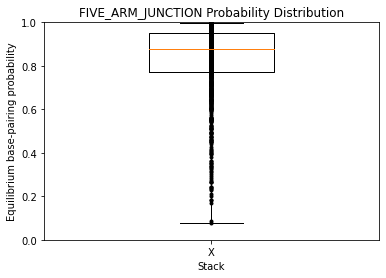

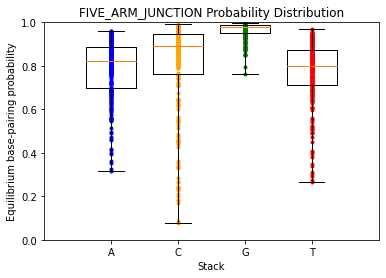

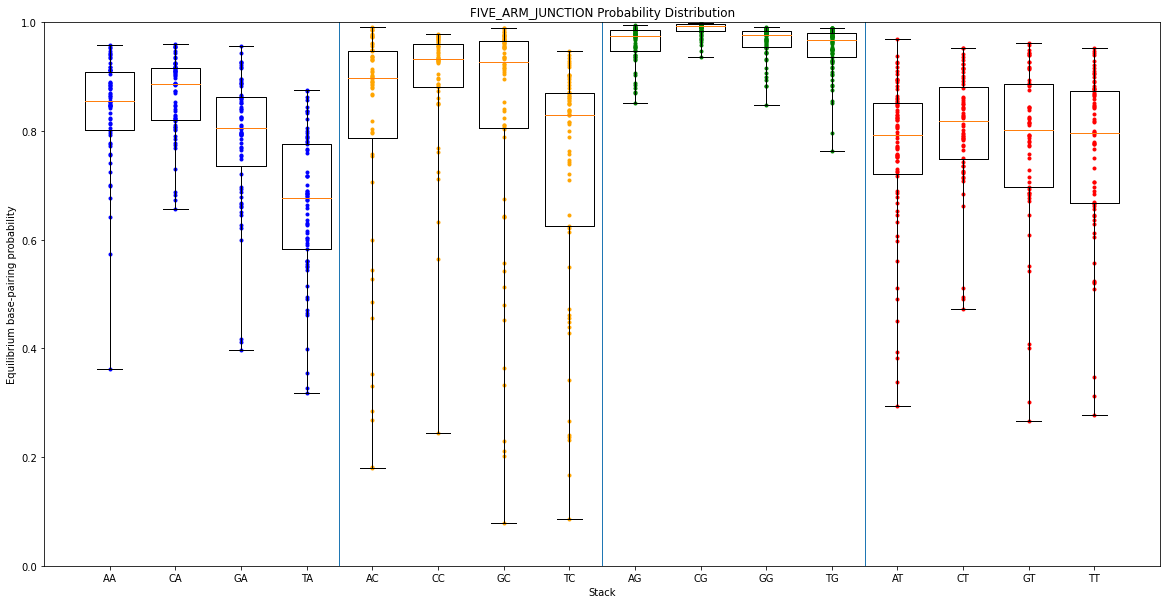

In [21]:
print('FIVE_ARM_JUNCTION')
top_strand_left: dc.Strand = dc.Strand(['a', 'b'], name='top strand left')
top_strand_right: dc.Strand = dc.Strand(['b*', 'c'], name='top strand right')
bot_strand_right: dc.Strand = dc.Strand(['c*', 'd'], name='bot strand right')
bot_strand_left: dc.Strand = dc.Strand(['d*', 'e'], name='bot strand left')
other_strand: dc.Strand = dc.Strand(['e*', 'a*'], name='other strand')
strands = (top_strand_left, top_strand_right, bot_strand_right, bot_strand_left, other_strand)

five_arm_junction_bppr = nupack_base_pair_probabilities(strands, 14, 135, 'FIVE_ARM_JUNCTION')
five_arm_junction_bppr.plot_all()

UNPAIRED
DEBUG: Domains to assign: {b, c, a}
DEBUG: Using strand index 0 and base index 24
Lower Quartile Probability: 0.6590820256777588


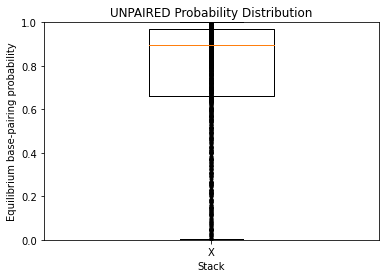

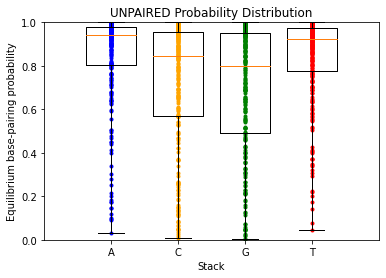

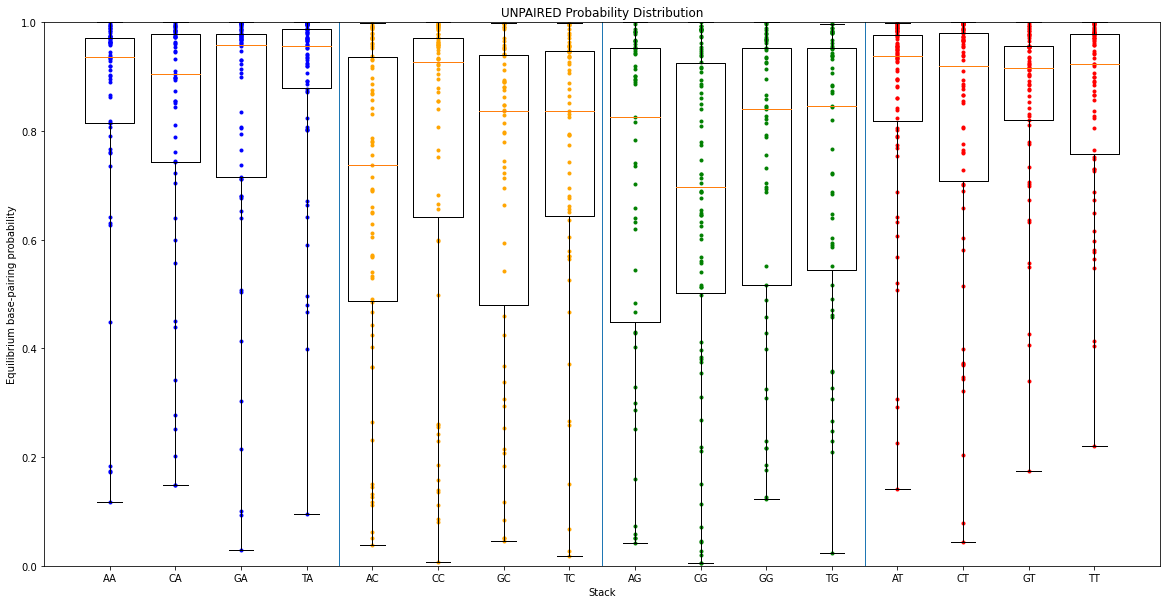

In [22]:
print('UNPAIRED')
#                       a      b
#                     0  14 15  29
#                     |   |  |   |
#                    [-----##----->
#                     |||||
#                    <-----##-----]
#                     |   |  |   |
#                     59 45  44  30
#                       a*    c
#                         ^
#                         |
#                     base pair

top_strand: dc.Strand = dc.Strand(['a', 'b'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['c', 'a*'], name='bot strand')
strands = (top_strand, bot_strand)

unpaired_bppr = nupack_base_pair_probabilities(strands, 24, 24, 'UNPAIRED')
unpaired_bppr.plot_all()

MISMATCH
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
0.9701523255491616
Lower Quartile Probability: 0.9523588010388377


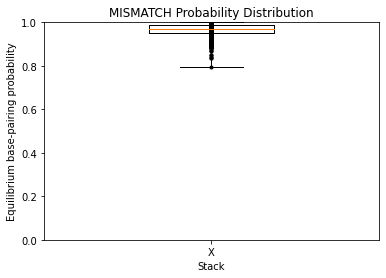

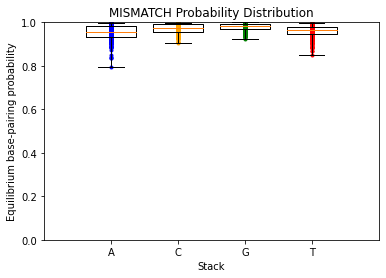

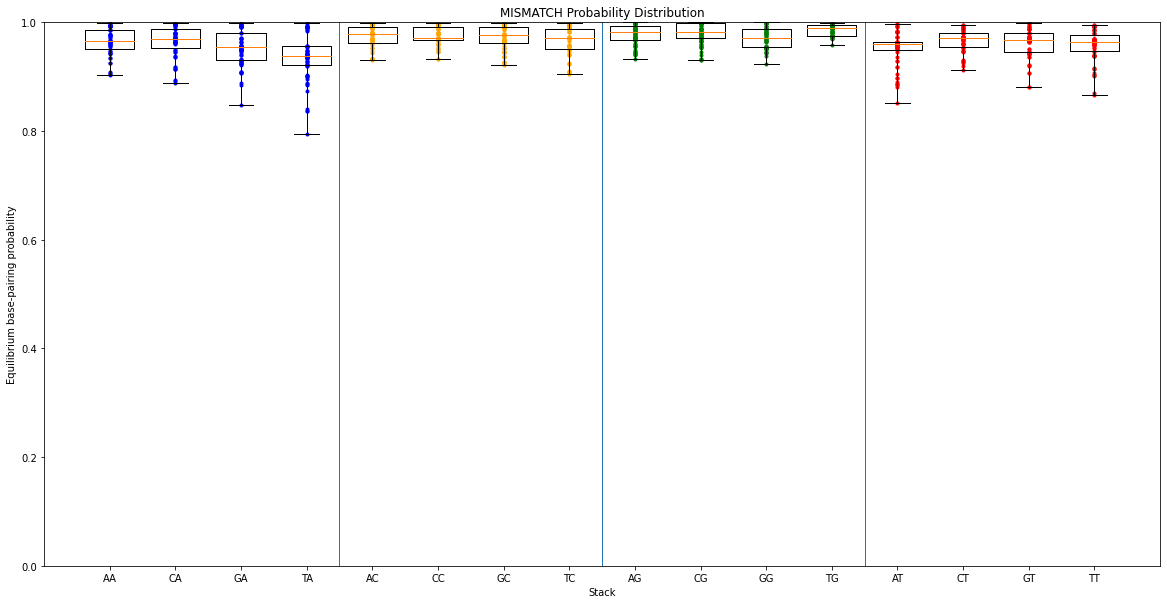

In [16]:
# TODO bulge loop

print('MISMATCH')
# MISMATCH
#                       a    b    c
#                     0  14  15 16  30
#                     |   |  |  |   |
#                    [-----##-##----->
#                     |||||     |||||
#                    <-----##-##-----]
#                     |   |  |  |   |
#                     61 47  46 45  31
#                       a*^  d   c*
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b', 'c'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['c*', 'd', 'a*'], name='bot strand')
    
pool_15 = dc.DomainPool('pool 15', 15)
pool_mismatch = dc.DomainPool('pool mismatch', 1)
top_strand.domains[0].pool = pool_15
top_strand.domains[1].pool = pool_mismatch
top_strand.domains[2].pool = pool_15
bot_strand.domains[0].pool = pool_15
bot_strand.domains[1].pool = pool_mismatch
bot_strand.domains[2].pool = pool_15

mismatches = [
    (StrandBaseAddress(0, 15), StrandBaseAddress(1, 15))
]

mismatch_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 14, 47, 'MISMATCH', skip_domain_pool_setup=True, mismatches=mismatches)
print(mismatch_bppr.percentile(50))
mismatch_bppr.plot_all()

MISMATCH
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
0.9915190359979491
Lower Quartile Probability: 0.9828334077730241


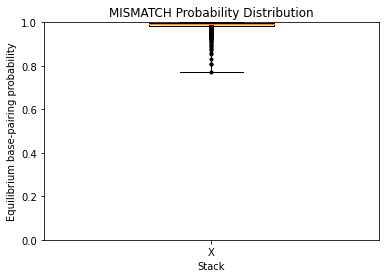

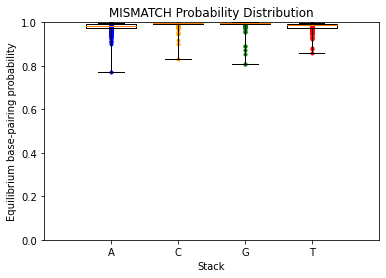

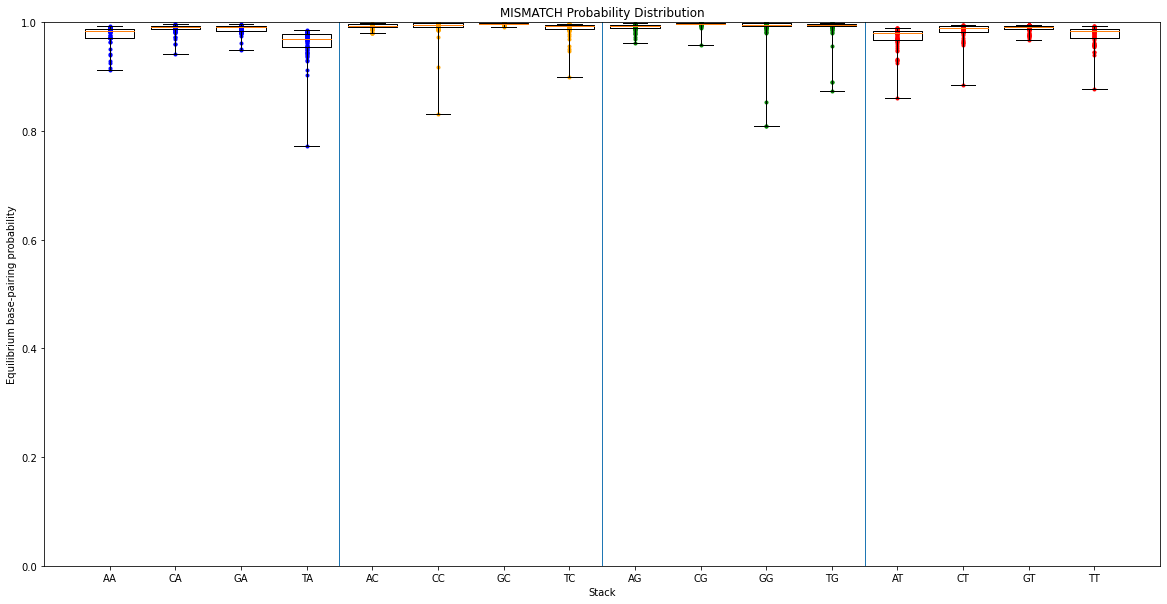

In [17]:
print('MISMATCH')
# MISMATCH
#                       a    b    c
#                     0  14 1516 17  31
#                     |   |  ||  |   |
#                    [-----##--##----->
#                     |||||      |||||
#                    <-----##--##-----]
#                     |   |  ||  |   |
#                     63 49 4847 46  32
#                       a*^  d   c*
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b', 'c'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['c*', 'd', 'a*'], name='bot strand')
    
pool_15 = dc.DomainPool('pool 15', 15)
pool_mismatch = dc.DomainPool('pool mismatch', 2)
top_strand.domains[0].pool = pool_15
top_strand.domains[1].pool = pool_mismatch
top_strand.domains[2].pool = pool_15
bot_strand.domains[0].pool = pool_15
bot_strand.domains[1].pool = pool_mismatch
bot_strand.domains[2].pool = pool_15

mismatches = [
    (StrandBaseAddress(0, 15), StrandBaseAddress(1, 16)),
    (StrandBaseAddress(0, 16), StrandBaseAddress(1, 15))
]

mismatch_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 14, 49, 'MISMATCH', skip_domain_pool_setup=True, mismatches=mismatches)
print(mismatch_bppr.percentile(50))
mismatch_bppr.plot_all()

MISMATCH 3
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
0.9569992444296493
Lower Quartile Probability: 0.9058634890903695


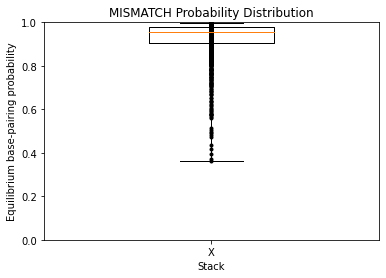

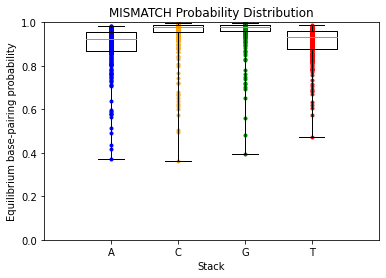

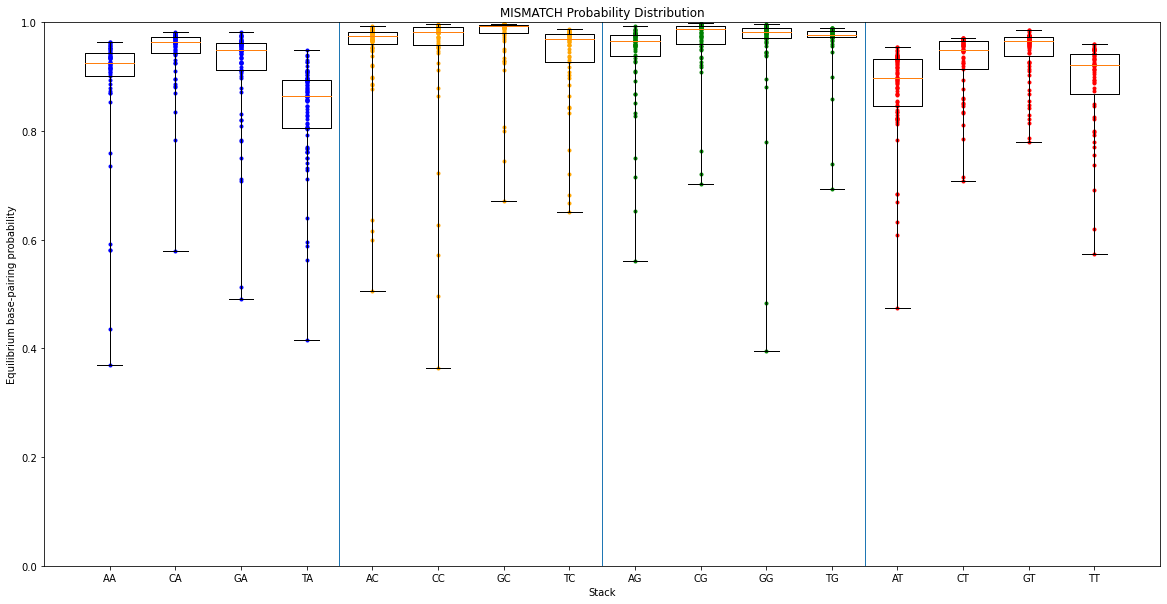

In [18]:
print('MISMATCH 3')
# MISMATCH
#                       a    b    c
#                     0  14 1567 18  32
#                     |   |  |||  |   |
#                    [-----##---##----->
#                     |||||       |||||
#                    <-----##---##-----]
#                     |   |  |||  |   |
#                     65 51  098 47  33
#                       a*^  d      c*
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b', 'c'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['c*', 'd', 'a*'], name='bot strand')
    
pool_15 = dc.DomainPool('pool 15', 15)
pool_mismatch = dc.DomainPool('pool mismatch', 3)
top_strand.domains[0].pool = pool_15
top_strand.domains[1].pool = pool_mismatch
top_strand.domains[2].pool = pool_15
bot_strand.domains[0].pool = pool_15
bot_strand.domains[1].pool = pool_mismatch
bot_strand.domains[2].pool = pool_15

mismatches = [
    (StrandBaseAddress(0, 15), StrandBaseAddress(1, 17)),
    (StrandBaseAddress(0, 16), StrandBaseAddress(1, 16)),
    (StrandBaseAddress(0, 17), StrandBaseAddress(1, 15))
]

mismatch_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 14, 51, 'MISMATCH', skip_domain_pool_setup=True, mismatches=mismatches)
print(mismatch_bppr.percentile(50))
mismatch_bppr.plot_all()

MISMATCH 4
DEBUG: Domains to assign: {d, b, c, a}
DEBUG: Using strand index 0 and base index 14
0.9764858437268698
Lower Quartile Probability: 0.9422263522015356


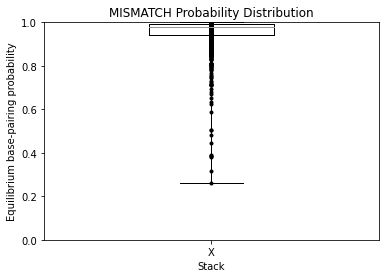

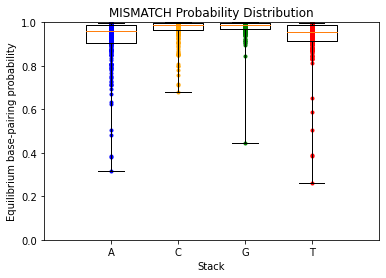

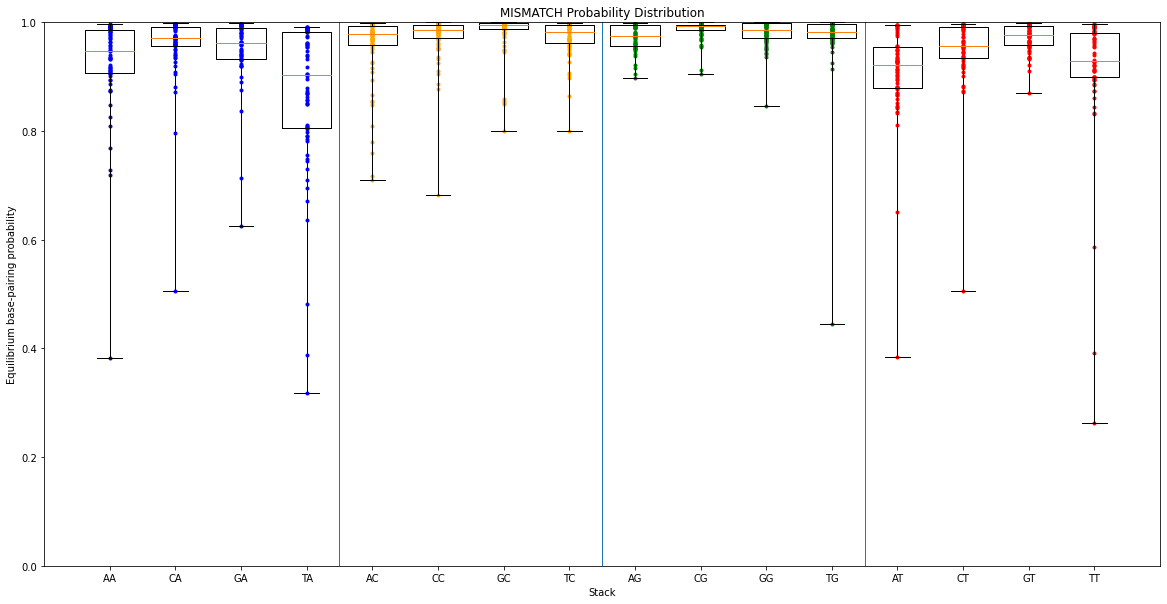

In [21]:
print('MISMATCH 4')
# MISMATCH
#                       a    b    c
#                     0  14 15678  19  33
#                     |   |  ||||  |   |
#                    [-----##----##----->
#                     |||||        |||||
#                    <-----##----##-----]
#                     |   |  |  |  |   |
#                     67 53  52 49 48   34
#                       a*^  d      c*
#                         |
#                     base pair
top_strand: dc.Strand = dc.Strand(['a', 'b', 'c'], name='top strand')
bot_strand: dc.Strand = dc.Strand(['c*', 'd', 'a*'], name='bot strand')
    
pool_15 = dc.DomainPool('pool 15', 15)
pool_mismatch = dc.DomainPool('pool mismatch', 4)
top_strand.domains[0].pool = pool_15
top_strand.domains[1].pool = pool_mismatch
top_strand.domains[2].pool = pool_15
bot_strand.domains[0].pool = pool_15
bot_strand.domains[1].pool = pool_mismatch
bot_strand.domains[2].pool = pool_15

mismatches = [
    (StrandBaseAddress(0, 15), StrandBaseAddress(1, 17)),
    (StrandBaseAddress(0, 16), StrandBaseAddress(1, 16)),
    (StrandBaseAddress(0, 17), StrandBaseAddress(1, 15))
]

mismatch_bppr = nupack_base_pair_probabilities((top_strand, bot_strand), 14, 53, 'MISMATCH', skip_domain_pool_setup=True, mismatches=mismatches)
print(mismatch_bppr.percentile(50))
mismatch_bppr.plot_all()

In [23]:
print(unpaired_bppr.upper_quartile())
print(unpaired_bppr.percentile(90))

0.9689001423182653
0.9903135479124208


In [24]:
from IPython.display import display
import pandas as pd
import math

# Constants
DATAFRAME_STYLE = [
    dict(selector="caption", 
    props=[
        ("text-align", "center"),
        ("font-size", "120%"),
        ("font-weight", "bold"),
        ("color", 'black'),
   ])
]

# Utility function for displaying data in a pandas DataFrame
def display_data(data: Dict, caption: str) -> None:
    display(pd.DataFrame(data).style.set_caption(caption).set_table_styles(DATAFRAME_STYLE))  

In [25]:
# Collect all results
base_pair_probability_results = [
    interior_to_strand_bppr,
    interior_adjacent_to_blunt_end_bppr,
    blunt_end_bppr,
    nick_3p_bppr,
    nick_5p_bppr,
    dangle_3p_bppr,
    dangle_5p_bppr,
    dangle_5p_3p_bppr,
    overhang_on_this_strand_3p_bppr,
    overhang_on_this_strand_5p_bppr,
    overhang_on_adj_strand_3p_bppr,
    overhang_on_adj_strand_5p_bppr,
    overhang_on_both_strand_3p_bppr,
    overhang_on_both_strand_5p_bppr,
    three_arm_junction_bppr,
    four_arm_junction_bppr,
    five_arm_junction_bppr,
    unpaired_bppr
]

display_data(
    {
        "Base Pair Type": [bppr.name for bppr in base_pair_probability_results],
        "Lower Quartile Probability": [bppr.lower_quartile() for bppr in base_pair_probability_results]
    },
    caption="Probability threshold for dsd"
)

print('Copy paste this to dsd:\n')

for bppr in base_pair_probability_results:
    print(f'default_{bppr.name.lower()}_probability = {math.floor(bppr.lower_quartile() * 100) / 100}')
    
percentile = 90
print('NOTE: Do not used lower quartile value for UNPAIRED. Opt for tighter threshold')
print(f'      For example, for {percentile} percnetile, choose {unpaired_bppr.percentile(percentile)}')
print('NOTE: Do not user lower quartile value for INTERIOR_TO_STRAND_BPPR because this\n',
      '      this value was sampled from a base pair in the middle of the strand.\n',
      '      Instead, use the value sampled from a base pair next to the end of a\n',
      '      blunt end:'
     )

for percentile in [25, 50, 75]:
    print(f'{percentile}th Percentile: {interior_adjacent_to_blunt_end_bppr.percentile(percentile)}')
    
# BELOW: OLD CODE displaying probability split by base pair
# Maps base to a sorted list of most probable base pair type
# sorted_base_pair_type_by_base: Dict[str, List[str]] = {}

# for base in 'ACGT':
#     # Sorts result by most probable base pair type
#     base_pair_probability_results = sorted(base_pair_probability_results, key=lambda bppr: -bppr.mean_by_base(base))
    
#     display_data(
#         {
#             "Base Pair Type": [bppr.name for bppr in base_pair_probability_results],
#             "Mean Probability": [bppr.mean_by_base(base) for bppr in base_pair_probability_results],
#             "Standard Deviation": [bppr.std_by_base(base) for bppr in base_pair_probability_results]
#         },
#         caption=f'Equilibrium Base Pair Probability (Base {base})'
#     )
    
#     # Collect sorted Base Pair Type for this base
#     sorted_base_pair_type_by_base[base] = [bppr.name for bppr in base_pair_probability_results]

# display_data(sorted_base_pair_type_by_base, 'Most Probabable Base Pair Type By Base')
#
# TODO:
# - Mismatch

# TODO:
# - Add some markup to this
# - Add it in repo in some folder

,Base Pair Type,Lower Quartile Probability
0,INTERIOR_TO_STRAND,0.995236
1,INTERIOR_ADJACENT_TO_BLUNT_END,0.882459
2,BLUNT_END,0.348391
3,NICK_3P,0.777856
4,NICK_5P,0.734052
5,DANGLE_3P,0.514025
6,DANGLE_5P,0.576308
7,DANGLE_5P_3P,0.739371
8,OVERHANG_ON_THIS_STRAND_3P,0.821676
9,OVERHANG_ON_THIS_STRAND_5P,0.785720


Copy paste this to dsd:

default_interior_to_strand_probability = 0.99
default_interior_adjacent_to_blunt_end_probability = 0.88
default_blunt_end_probability = 0.34
default_nick_3p_probability = 0.77
default_nick_5p_probability = 0.73
default_dangle_3p_probability = 0.51
default_dangle_5p_probability = 0.57
default_dangle_5p_3p_probability = 0.73
default_overhang_on_this_strand_3p_probability = 0.82
default_overhang_on_this_strand_5p_probability = 0.78
default_overhang_on_adjacent_strand_3p_probability = 0.55
default_overhang_on_adjacent_strand_5p_probability = 0.5
default_overhang_on_both_strand_3p_probability = 0.61
default_overhang_on_both_strand_5p_probability = 0.59
default_three_arm_junction_probability = 0.69
default_four_arm_junction_probability = 0.84
default_five_arm_junction_probability = 0.77
default_unpaired_probability = 0.65
NOTE: Do not used lower quartile value for UNPAIRED. Opt for tighter threshold
      For example, for 90 percnetile, choose 0.9903135479124208
NOTE